In [1]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
#import pandas as pd
from matplotlib.patches import Rectangle, Circle
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import WCSAxes, add_beam
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from matplotlib import pyplot, image, transforms

In [2]:
#Image import

#Hubble - F435W
hubble = fits.open("j92103040_drz.fits")[1]
wcsHubble = WCS(hubble.header)

#Chandra - NGC6266
hduChandra = fits.open("Chandra/NGC6266/primary/acisf02677N004_cntr_img2.fits")[0] #3040_drz.chip1.fits is what I've been using so far
wcsChandra = WCS(hduChandra.header)

Set MJD-END to 52407.130104 from DATE-END'. [astropy.wcs.wcs]


In [6]:
#Data import

xPos, yPos, C, objType, error, sharpness, roundness, crowding, mag435, sig435, mag625, sig625, mag658, sig658, counts435, counts625, counts658 = np.loadtxt('noAlignment/magsNoAlignment.txt', unpack = True)
sep, chandraRAh, chandraRAm, chandraRAs, chandraDECd, chandraDECm, chandraDECs, chandraErrR1, chandraErrR2, chandraErrTheta, sigma, flux, fluxH, fluxM, fluxS = np.loadtxt('chandra2.txt', unpack=True)


In [8]:
#Define class for candidates

class candidate:
    def __init__(self, name, parent, X, Y, chi, objType, error, sharpness, roundness, crowding, mag435, sig435, mag625, sig625, mag658, sig658, brColor, hrColor, optFlux):
        self.name = name #name
        self.parent = parent #which chandra object is this candidate associated with?
        self.X = X #pixel horizontal position on hubble
        self.Y = Y #pixel vertical position
        self.chi = chi
        self.objType = objType #DOLPHOT object type
        self.error = error #DOLPHOT error flag
        self.sharpness = sharpness
        self.roundness = roundness
        self.crowding = crowding
        self.mag435 = mag435
        self.sig435 = sig435
        self.mag625 = mag625
        self.sig625 = sig625
        self.mag658 = mag658
        self.sig658 = sig658
        self.brColor = brColor
        self.hrColor = hrColor
        #self.flux435 = counts435 #m = C - 2.5logF    C ~= 33.874
        #self.flux625 = counts625
        #self.flux658 = counts658
        self.flux = optFlux
        
    
    
#and a class for Chandra objects
class chandra:
    def __init__(self, target, name, RA, DEC, errorR1, errorR2, errorTheta, sigma, X, Y, lx, flux, fluxH, fluxM, fluxS, emitter, starType, confidence):
        self.target = target
        self.name = name
        self.RA = RA #detection RA, reported by chandra
        self.DEC = DEC #detected DEC
        self.errorR1 = errorR1 #major axis error in arcseconds
        self.errorR2 = errorR2 #minor axis error in arcseconds
        self.errorTheta = errorTheta #angle from true north of the error elipse
        self.sigma = sigma
        self.X = X #pixel horizontal position, calculated onto hubble
        self.Y = Y #pixel vertical position
        self.lx = lx #x-ray luminosity, in ergs/s
        self.flux = flux #flux, in ergs/s/cm^2
        self.fluxHard = fluxH
        self.fluxMedium = fluxM
        self.fluxSoft = fluxS
        self.emitter = emitter
        self.starType = starType
        self.confidence = confidence

In [9]:
#Create list of Chandra targets

def isWithinHalfLight(ra, dec): #for excluding distant Chandra objects
    
    pos = SkyCoord(RA, DEC, frame='icrs')
    pos = pos.transform_to('fk5') #converting to match Hubble ACS
    x, y = wcsHubble.world_to_pixel_values(pos.ra, pos.dec) #x, y position of chandra star
    
    centerRA, centerDEC = '17h01m12.60s', '-30d06m44.5s' #center of cluster via SIMBAD

    posCenter = SkyCoord(centerRA, centerDEC, frame='icrs')
    posCenter = posCenter.transform_to('fk5') #converting to match Hubble ACS
    xCenter, yCenter = wcsHubble.world_to_pixel_values(posCenter.ra, posCenter.dec) #x & y pixel position of cluster center
    
    #is the candidate star within the half-light radius of this cluster?
    
    if ((x - xCenter)**2 + (y-yCenter)**2)**(1/2) <= 1159:
        return True
    else:
        return False


chandraTargets = []

for i in range(len(chandraRAh)):
    
    #raOffset = 

    RA = str(int(chandraRAh[i]))+'h'+str(int(chandraRAm[i]))+'m'+str(chandraRAs[i])+'s'
    DEC = str(int(chandraDECd[i]))+'d'+str(int(chandraDECm[i]))+'m'+str(chandraDECs[i])+'s'


    pos = SkyCoord(RA, DEC, frame='icrs')
    pos = pos.transform_to('fk5') #converting to match Hubble ACS
    x, y = wcsHubble.world_to_pixel_values(pos.ra, pos.dec)

    #Add boresight offsets
    x = x - 0.5981686426266606
    y = y -1.69229899126276
    
    #Correct ra & dec to match
    temp = wcsHubble.pixel_to_world(x, y)
    temp = temp.transform_to('icrs')
    RA = temp.ra
    DEC = temp.dec

    if i < 9:
        targName = "CX0" + str(i+1)
    else:
        targName = "CX" + str(i+1)

    #Convert flux to units of ergs/s
    #Distance = 6470 pc * (3.086E13 km/pc) = 1.997E17 km = 1.997E20 m = 1.997E22 cm
    distCM = 1.997e22
    area = 4*math.pi*(distCM**2) #surface area of chandra star at our current distance
    totalLX = flux[i] * area #total flux emitted from star should be whatever we measure times the surface area in cm^2
    
    #Include boresight offsets for chandraTargets[7] to align with known VLA source    
    chandraTarget = chandra("6266", targName, RA, DEC, 21*chandraErrR1[i], 21*chandraErrR2[i], chandraErrTheta[i], sigma[i], float(x), float(y), totalLX, flux[i], fluxH[i], fluxM[i], fluxS[i], '', '', '')
    if isWithinHalfLight(chandraTarget.RA, chandraTarget.DEC):
        chandraTargets.append(chandraTarget)

In [14]:
#Create a set of filters to iterate over
def scale_plot_size(factor=10):
    default_dpi = plt.rcParamsDefault['figure.dpi']
    plt.rcParams['figure.dpi'] = default_dpi*factor
    plt.rcParams['agg.path.chunksize'] = 1000

scale_plot_size(10)


def Filter(crowdingMax, roundnessMax, sharpnessMin, sharpnessMax, chiMax):
    
    
    global dolphotObjects
    dolphotObjects = []
    global candidates 
    candidates = []

    for i in range(len(objType)):
        if ((mag435[i] != 99.999) and (mag625[i] != 99.999) and (mag658[i] != 99.999) and (error[i] <= 3) and (objType[i] < 3) and (C[i] <= chiMax) and (crowding[i] <= crowdingMax) and (roundness[i] <= roundnessMax) and (sharpness[i] <= sharpnessMax) and (sharpness[i] >= sharpnessMin)):
            if i < 9:
                targName = "H_0" + str(i+1)
            else:
                targName = "H_" + str(i+1)
            
            optFlux = 1.07*10**(-(0.4*mag625[i]+6)) #from lugger (2017) section 4.5
            hubbleTarget = candidate(targName, "none", xPos[i], yPos[i], C[i], objType[i], error[i], sharpness[i], roundness[i], crowding[i], mag435[i], sig435[i], mag625[i], sig625[i], mag658[i], sig658[i], mag435[i]-mag625[i], mag658[i]-mag625[i], optFlux)
            dolphotObjects.append(hubbleTarget)
        
   
    for field in fields:
    
        #field is the image number, but python iterates from 0, so target will be field-1
        target = field-1
        
        for j in range(len(dolphotObjects)):
            if (((dolphotObjects[j].X - chandraTargets[target].X)**2+(dolphotObjects[j].Y - chandraTargets[target].Y)**2)**(1/2)) <= chandraTargets[target].errorR1:
                #Add these to a list of candidates
                dolphotObjects[j].parent = chandraTargets[target].name
                candidates.append(dolphotObjects[j])
        
        
        xMin = int(chandraTargets[target].X-50)
        xMax = int(chandraTargets[target].X+50)
        yMin = int(chandraTargets[target].Y-50)
        yMax = int(chandraTargets[target].Y+50)
        
        
        image_data_Hubble = hubble.data
        plotDataHubble = image_data_Hubble[xMin:xMax, yMin:yMax]

        fig, ax = plt.subplots()

        title = chandraTargets[target].name + ": cMax=" + str(crowdingMax) + ", rMax=" + str(roundnessMax) + ", " + str(sharpnessMin) + "<= s <= " + str(sharpnessMax) + ", chiMax=" + str(chiMax)
        plt.title(title)
        ax.imshow(image_data_Hubble, origin = 'lower', vmin= -5e3, vmax = 5e3, cmap = 'gray_r')
        ax.set_xlim(xMin, xMax)
        ax.set_ylim(yMin, yMax)
        
        r = Rectangle((chandraTargets[target].X-1, chandraTargets[target].Y-1), 1, 1, edgecolor = 'blue', facecolor = 'none')#, transform = ax.get_transform('pixel'))
        ax.add_patch(r)
        
        c = Circle((chandraTargets[target].X, chandraTargets[target].Y), chandraTargets[target].errorR1, edgecolor = 'yellow', facecolor = 'none')
        ax.add_patch(c)
        
        for j in range(len(candidates)):
            if candidates[j].parent == chandraTargets[target].name: #and candidates[j].mag625 >= 20.5:
                r2 = Rectangle((candidates[j].X-0.5,candidates[j].Y-0.5), 1, 1, edgecolor = 'green', facecolor = 'none')
                ax.add_patch(r2)
                
        directory = 'C:\\Python\\' + str(crowdingMax) + '_' + str(roundnessMax) + '_' + str(sharpnessMin) + '_' + str(sharpnessMax) + '_' + str(chiMax) + '\\'
        #directory = 'C:\\Python\\CMDFiltered'  
        if not os.path.isdir(directory):
          os.mkdir(directory)
 
          
        f = directory + chandraTargets[target].name + '___' + str(crowdingMax) + '_' + str(roundnessMax) + '_' + str(sharpnessMin) + '_' + str(sharpnessMax) + '_' + str(chiMax) + '.png'
        f = directory + chandraTargets[target].name + '.png'
        plt.savefig(f, bbox_inches='tight')
        plt.show()
        plt.close(fig)

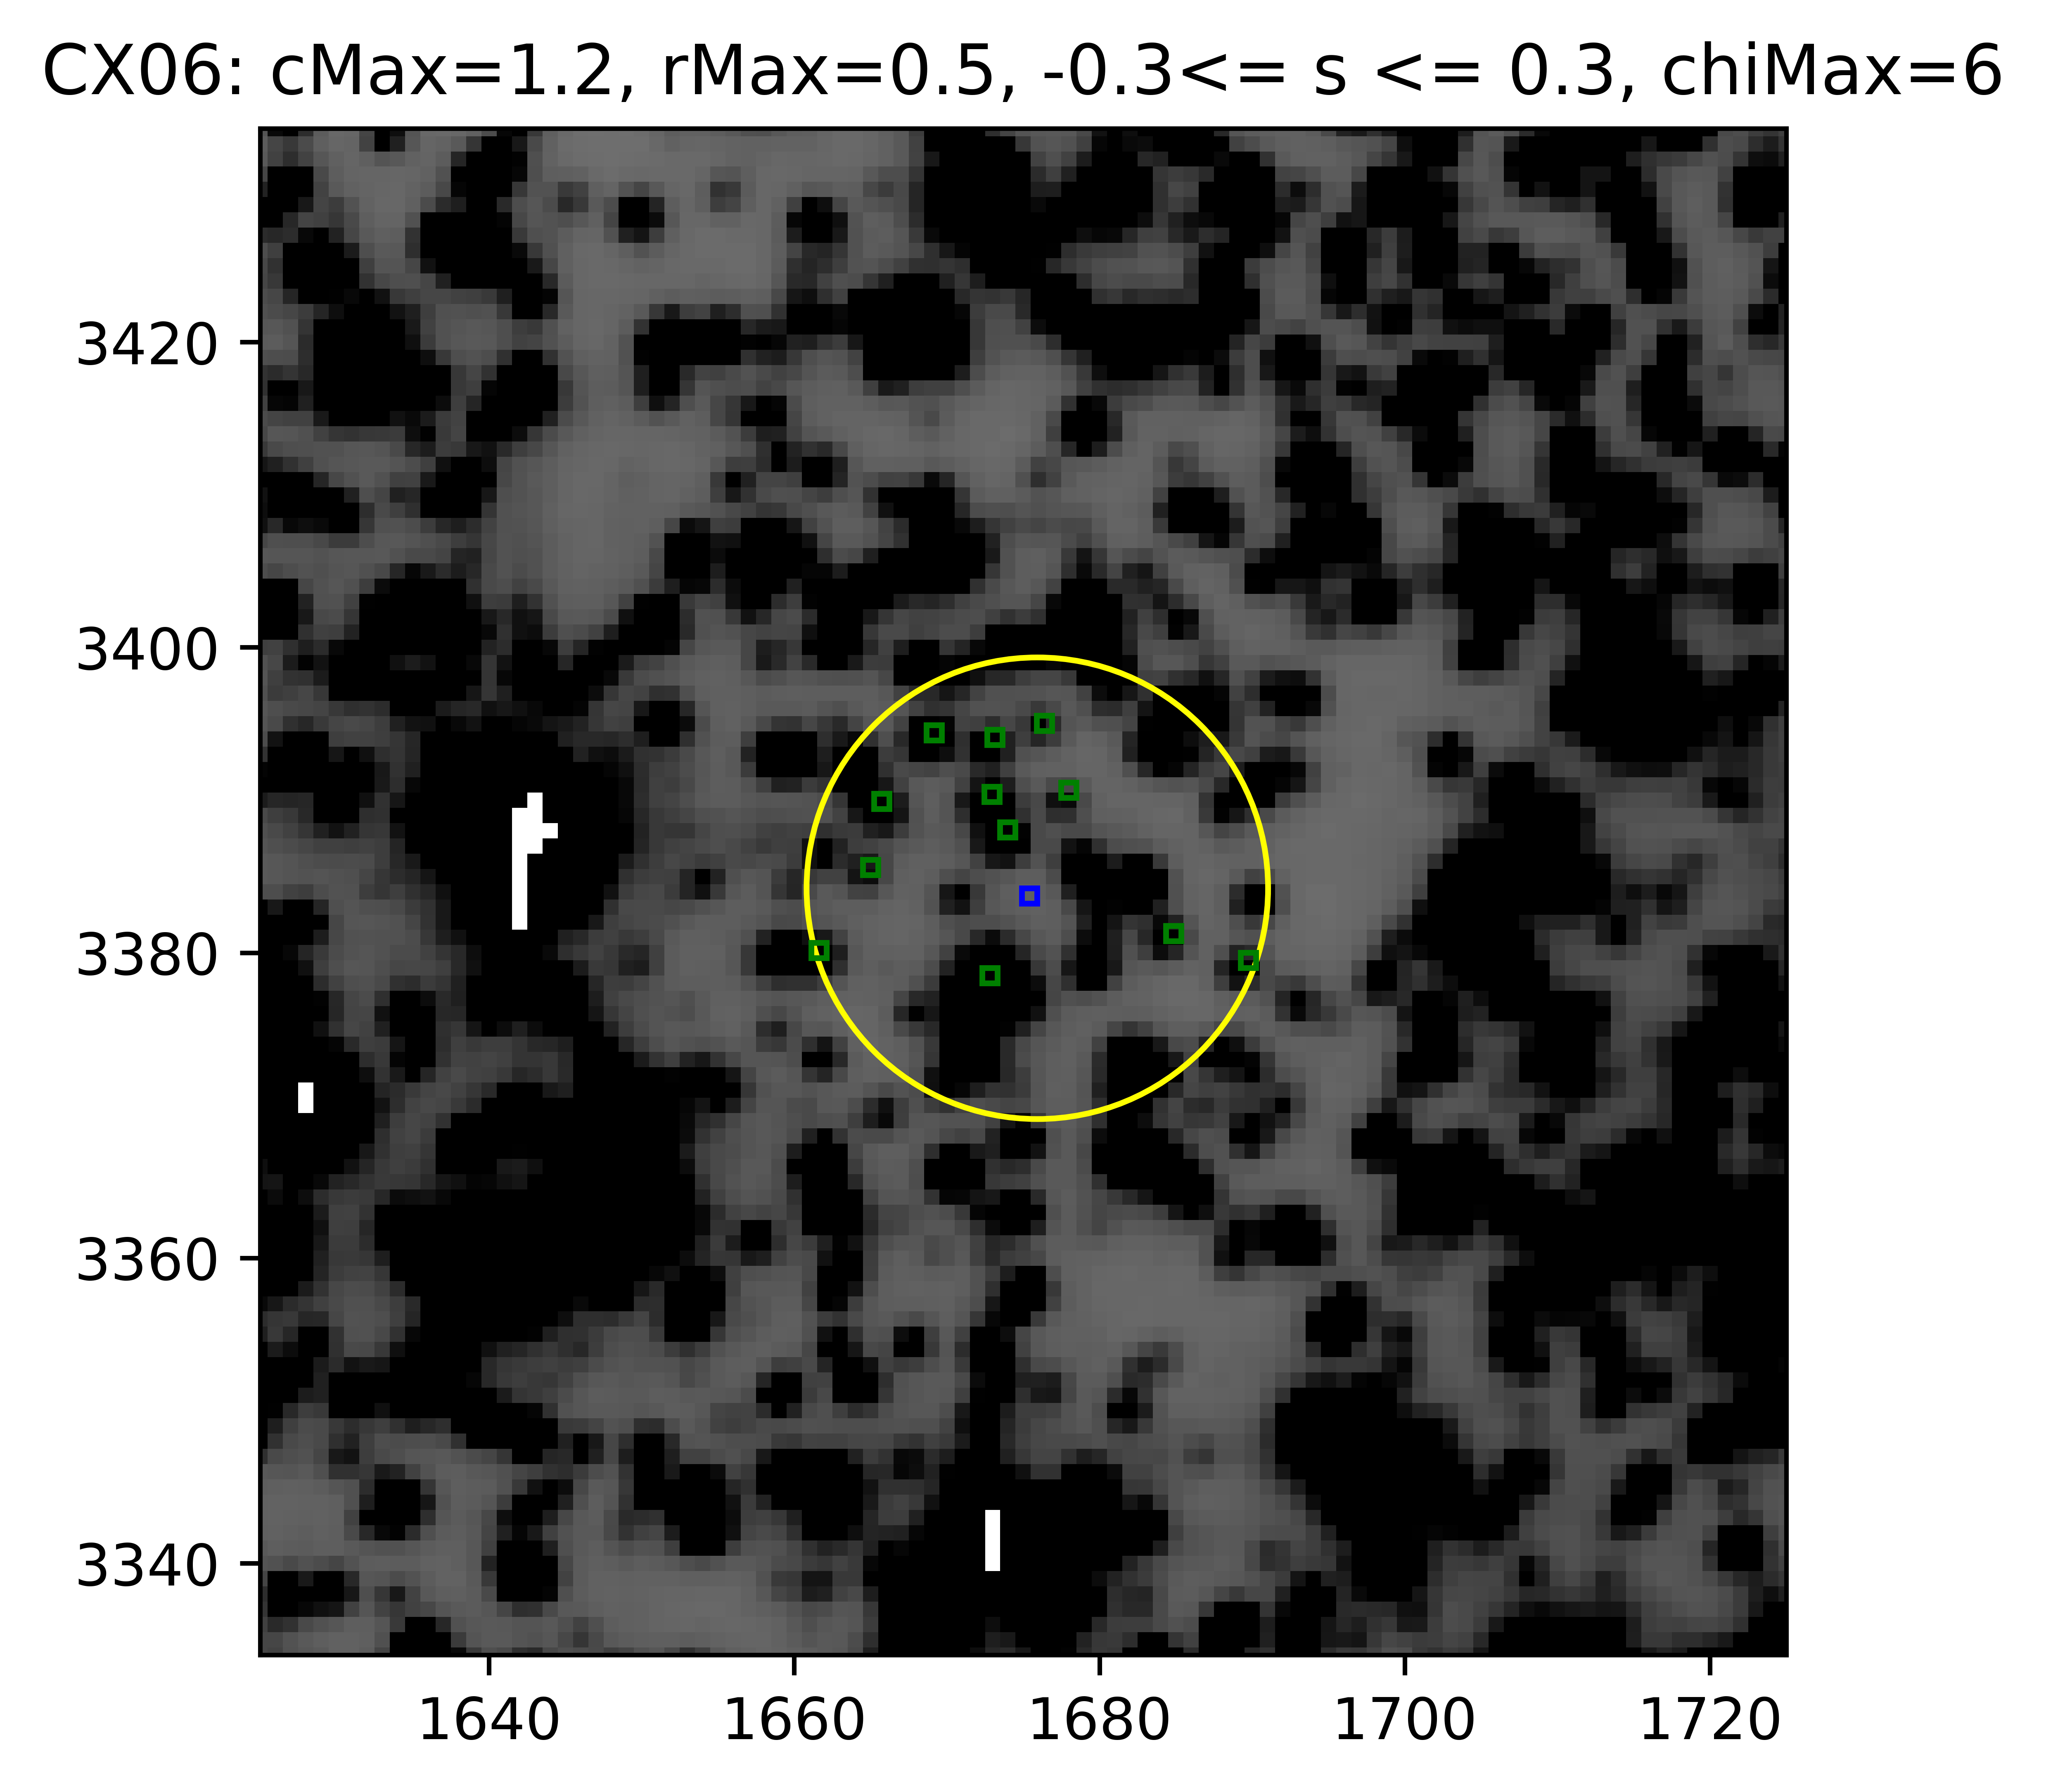

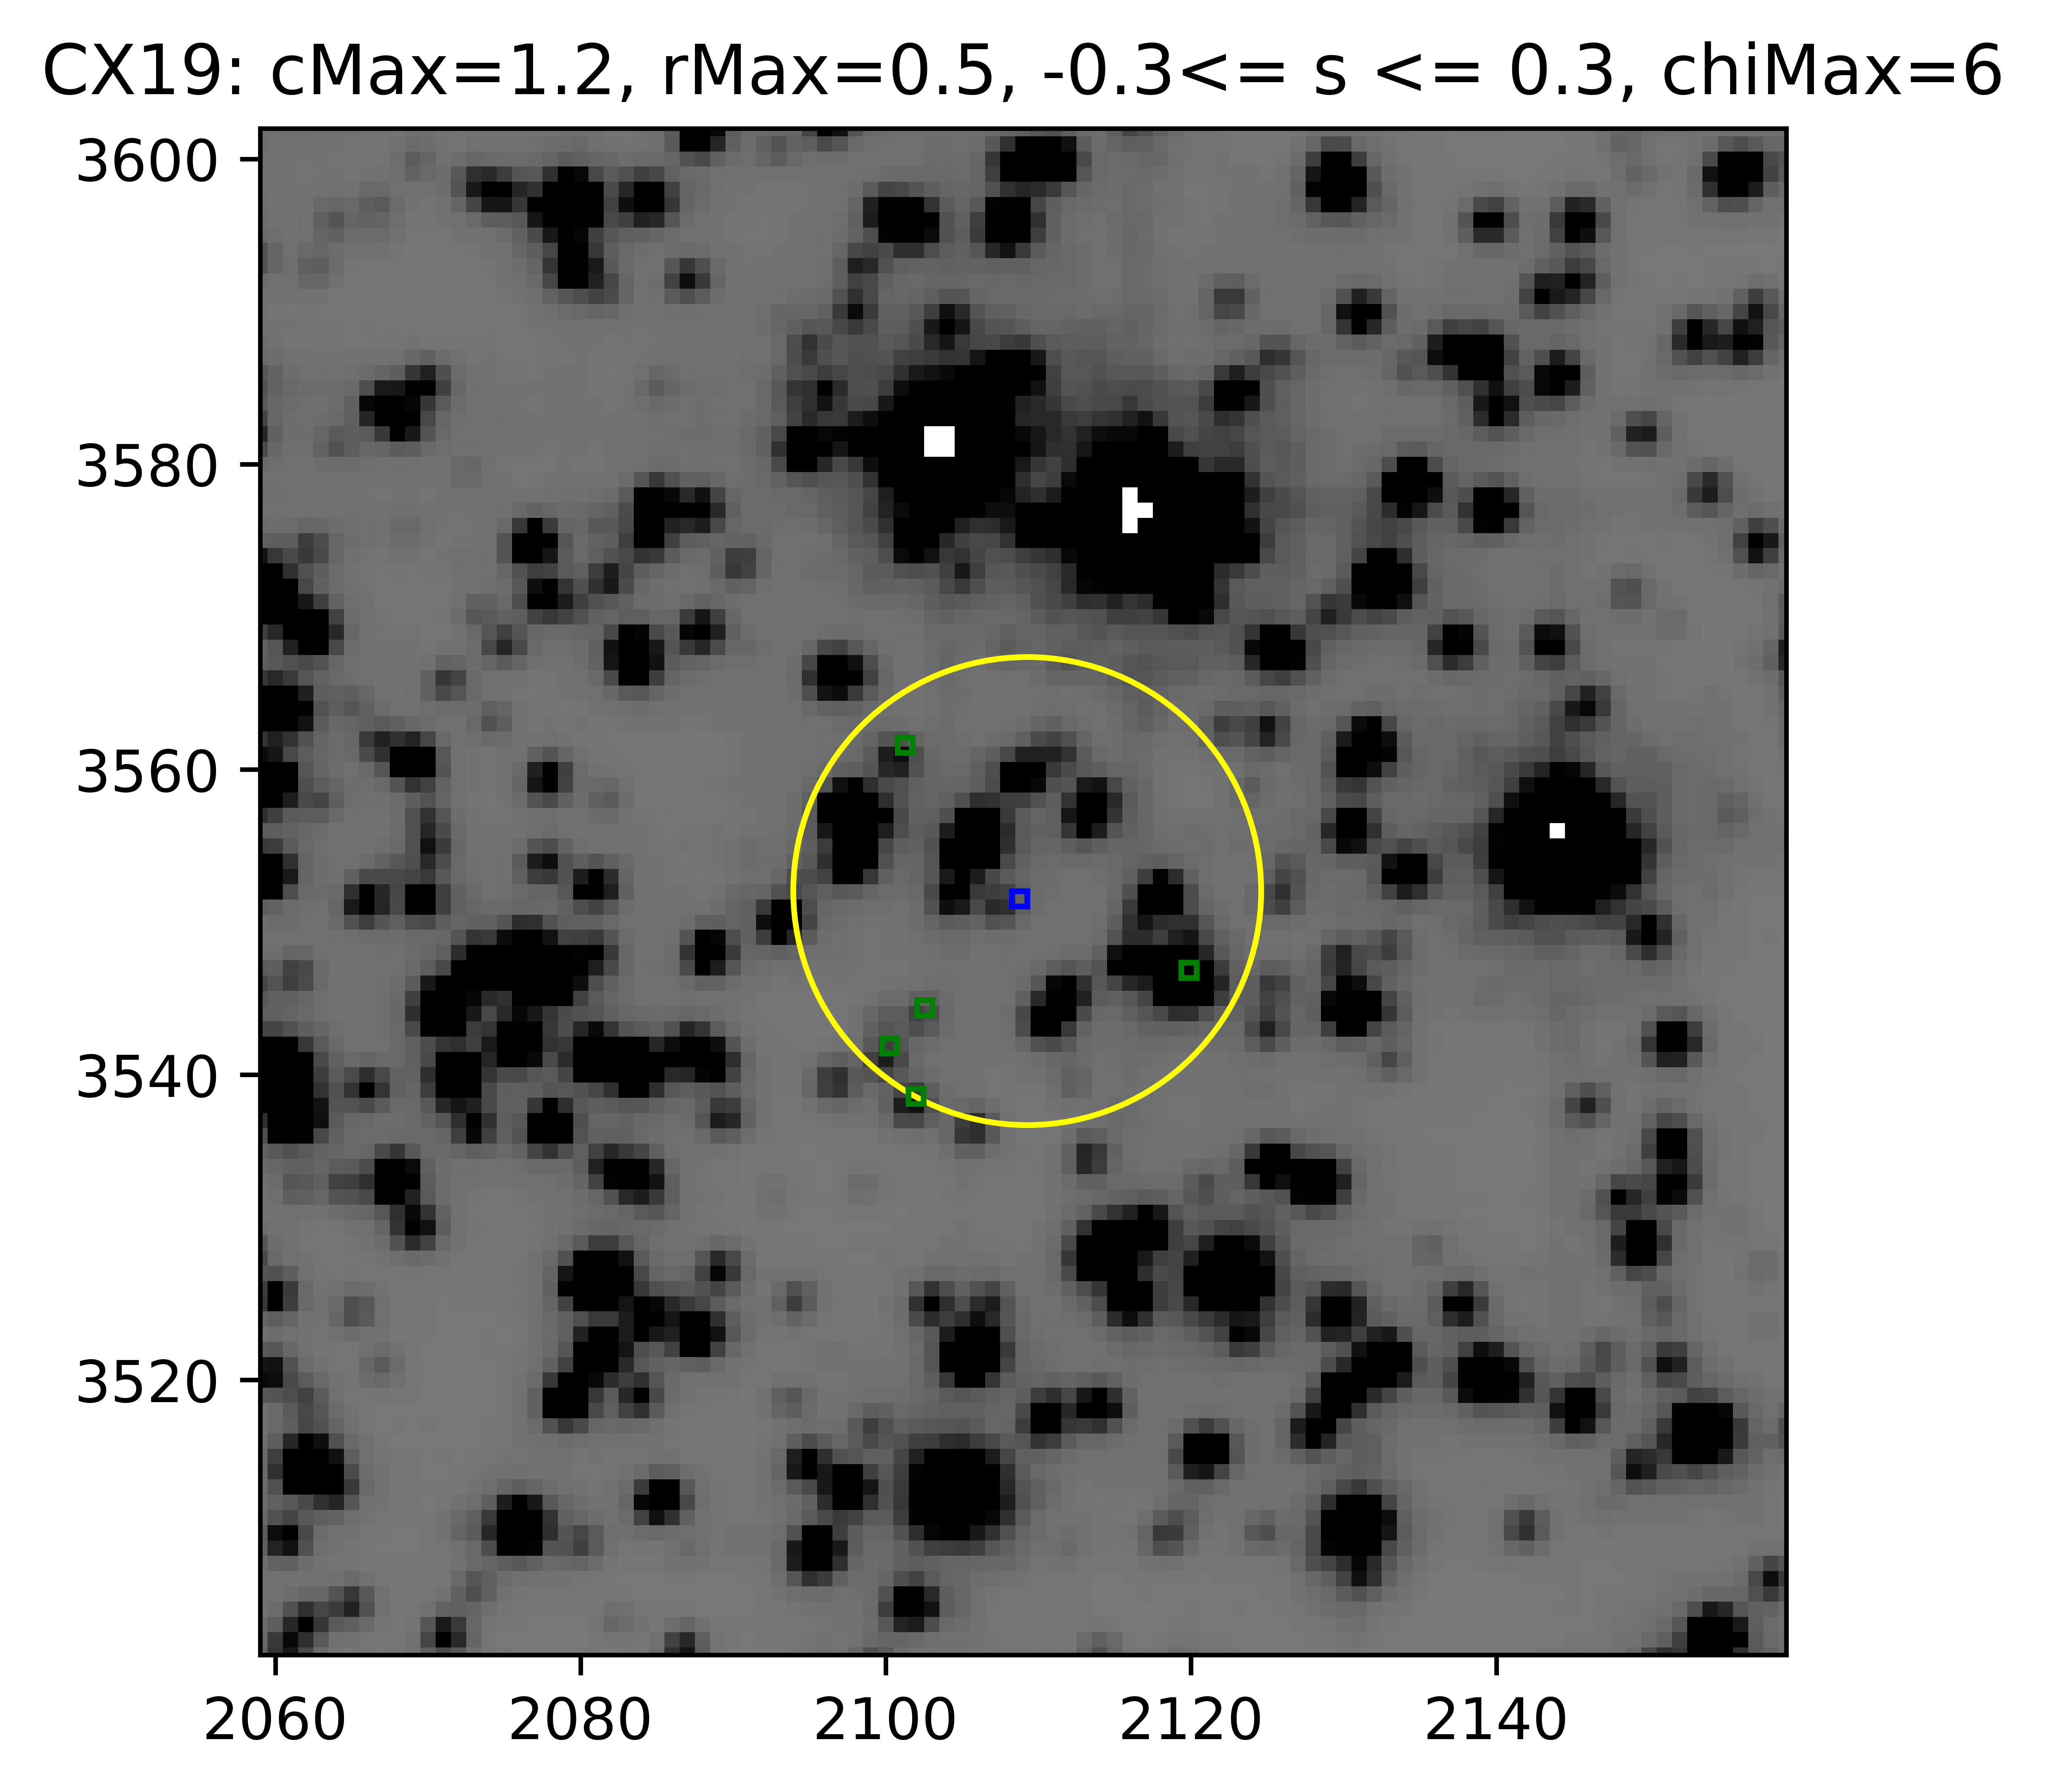

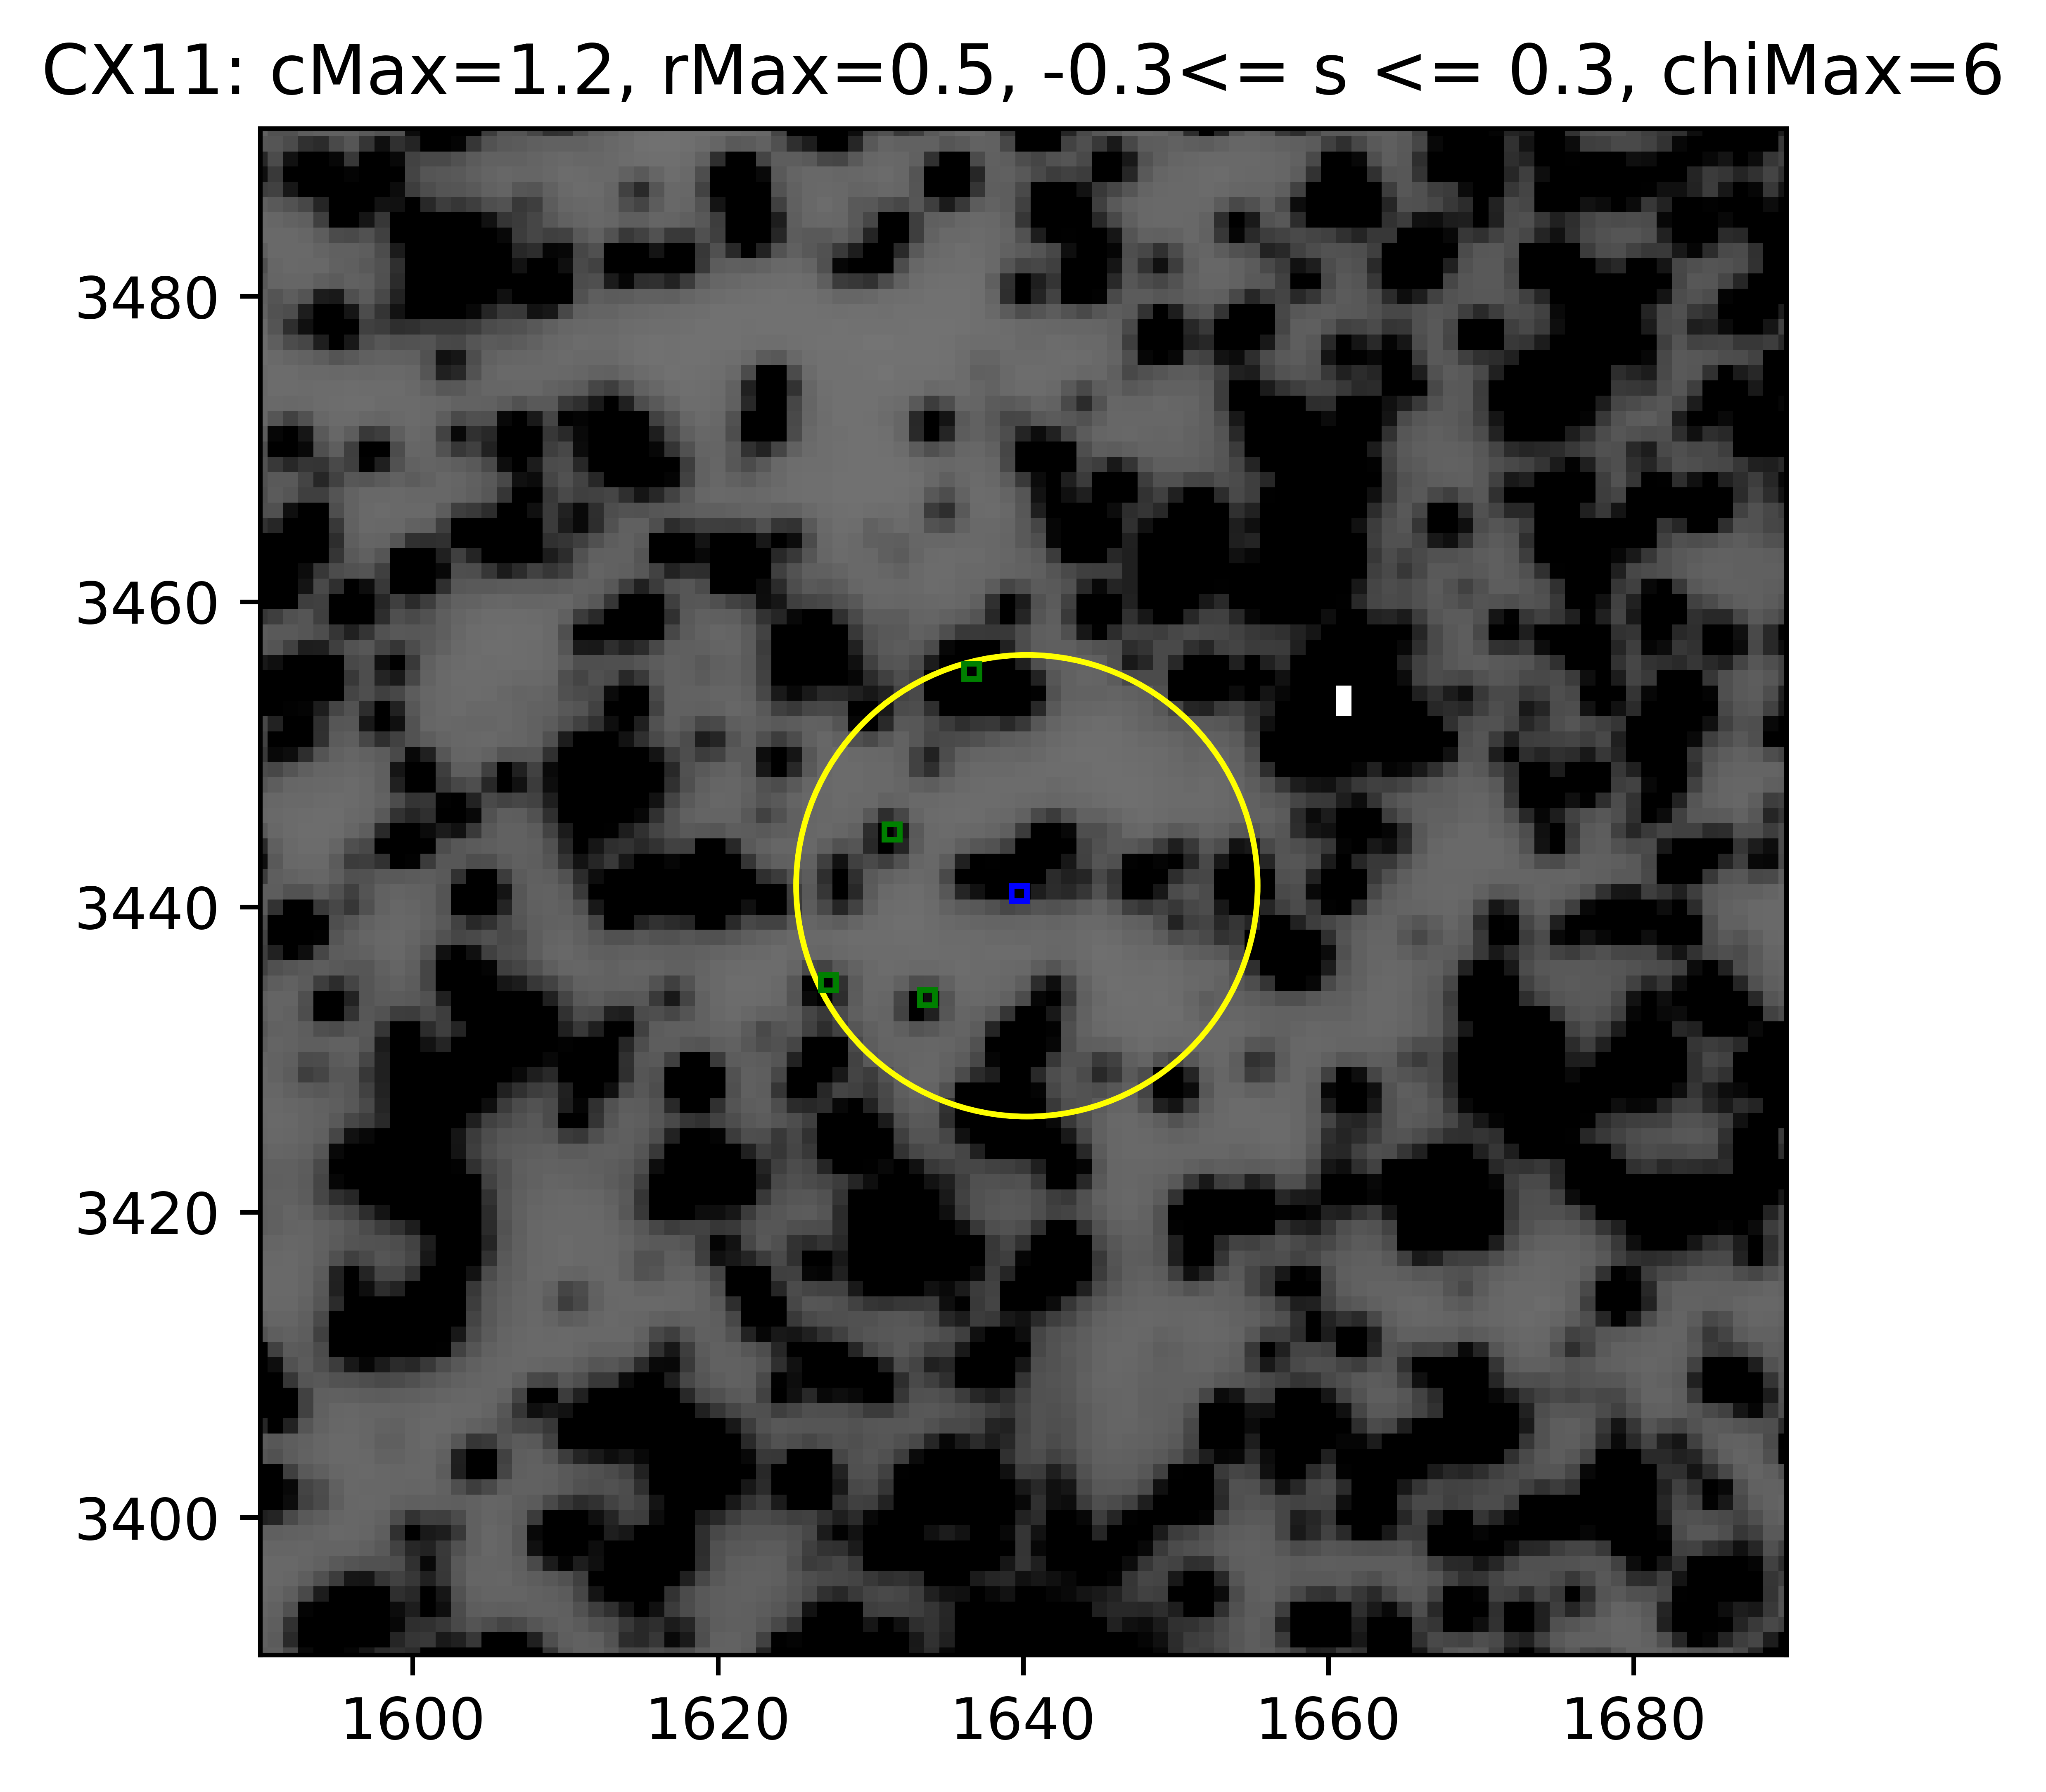

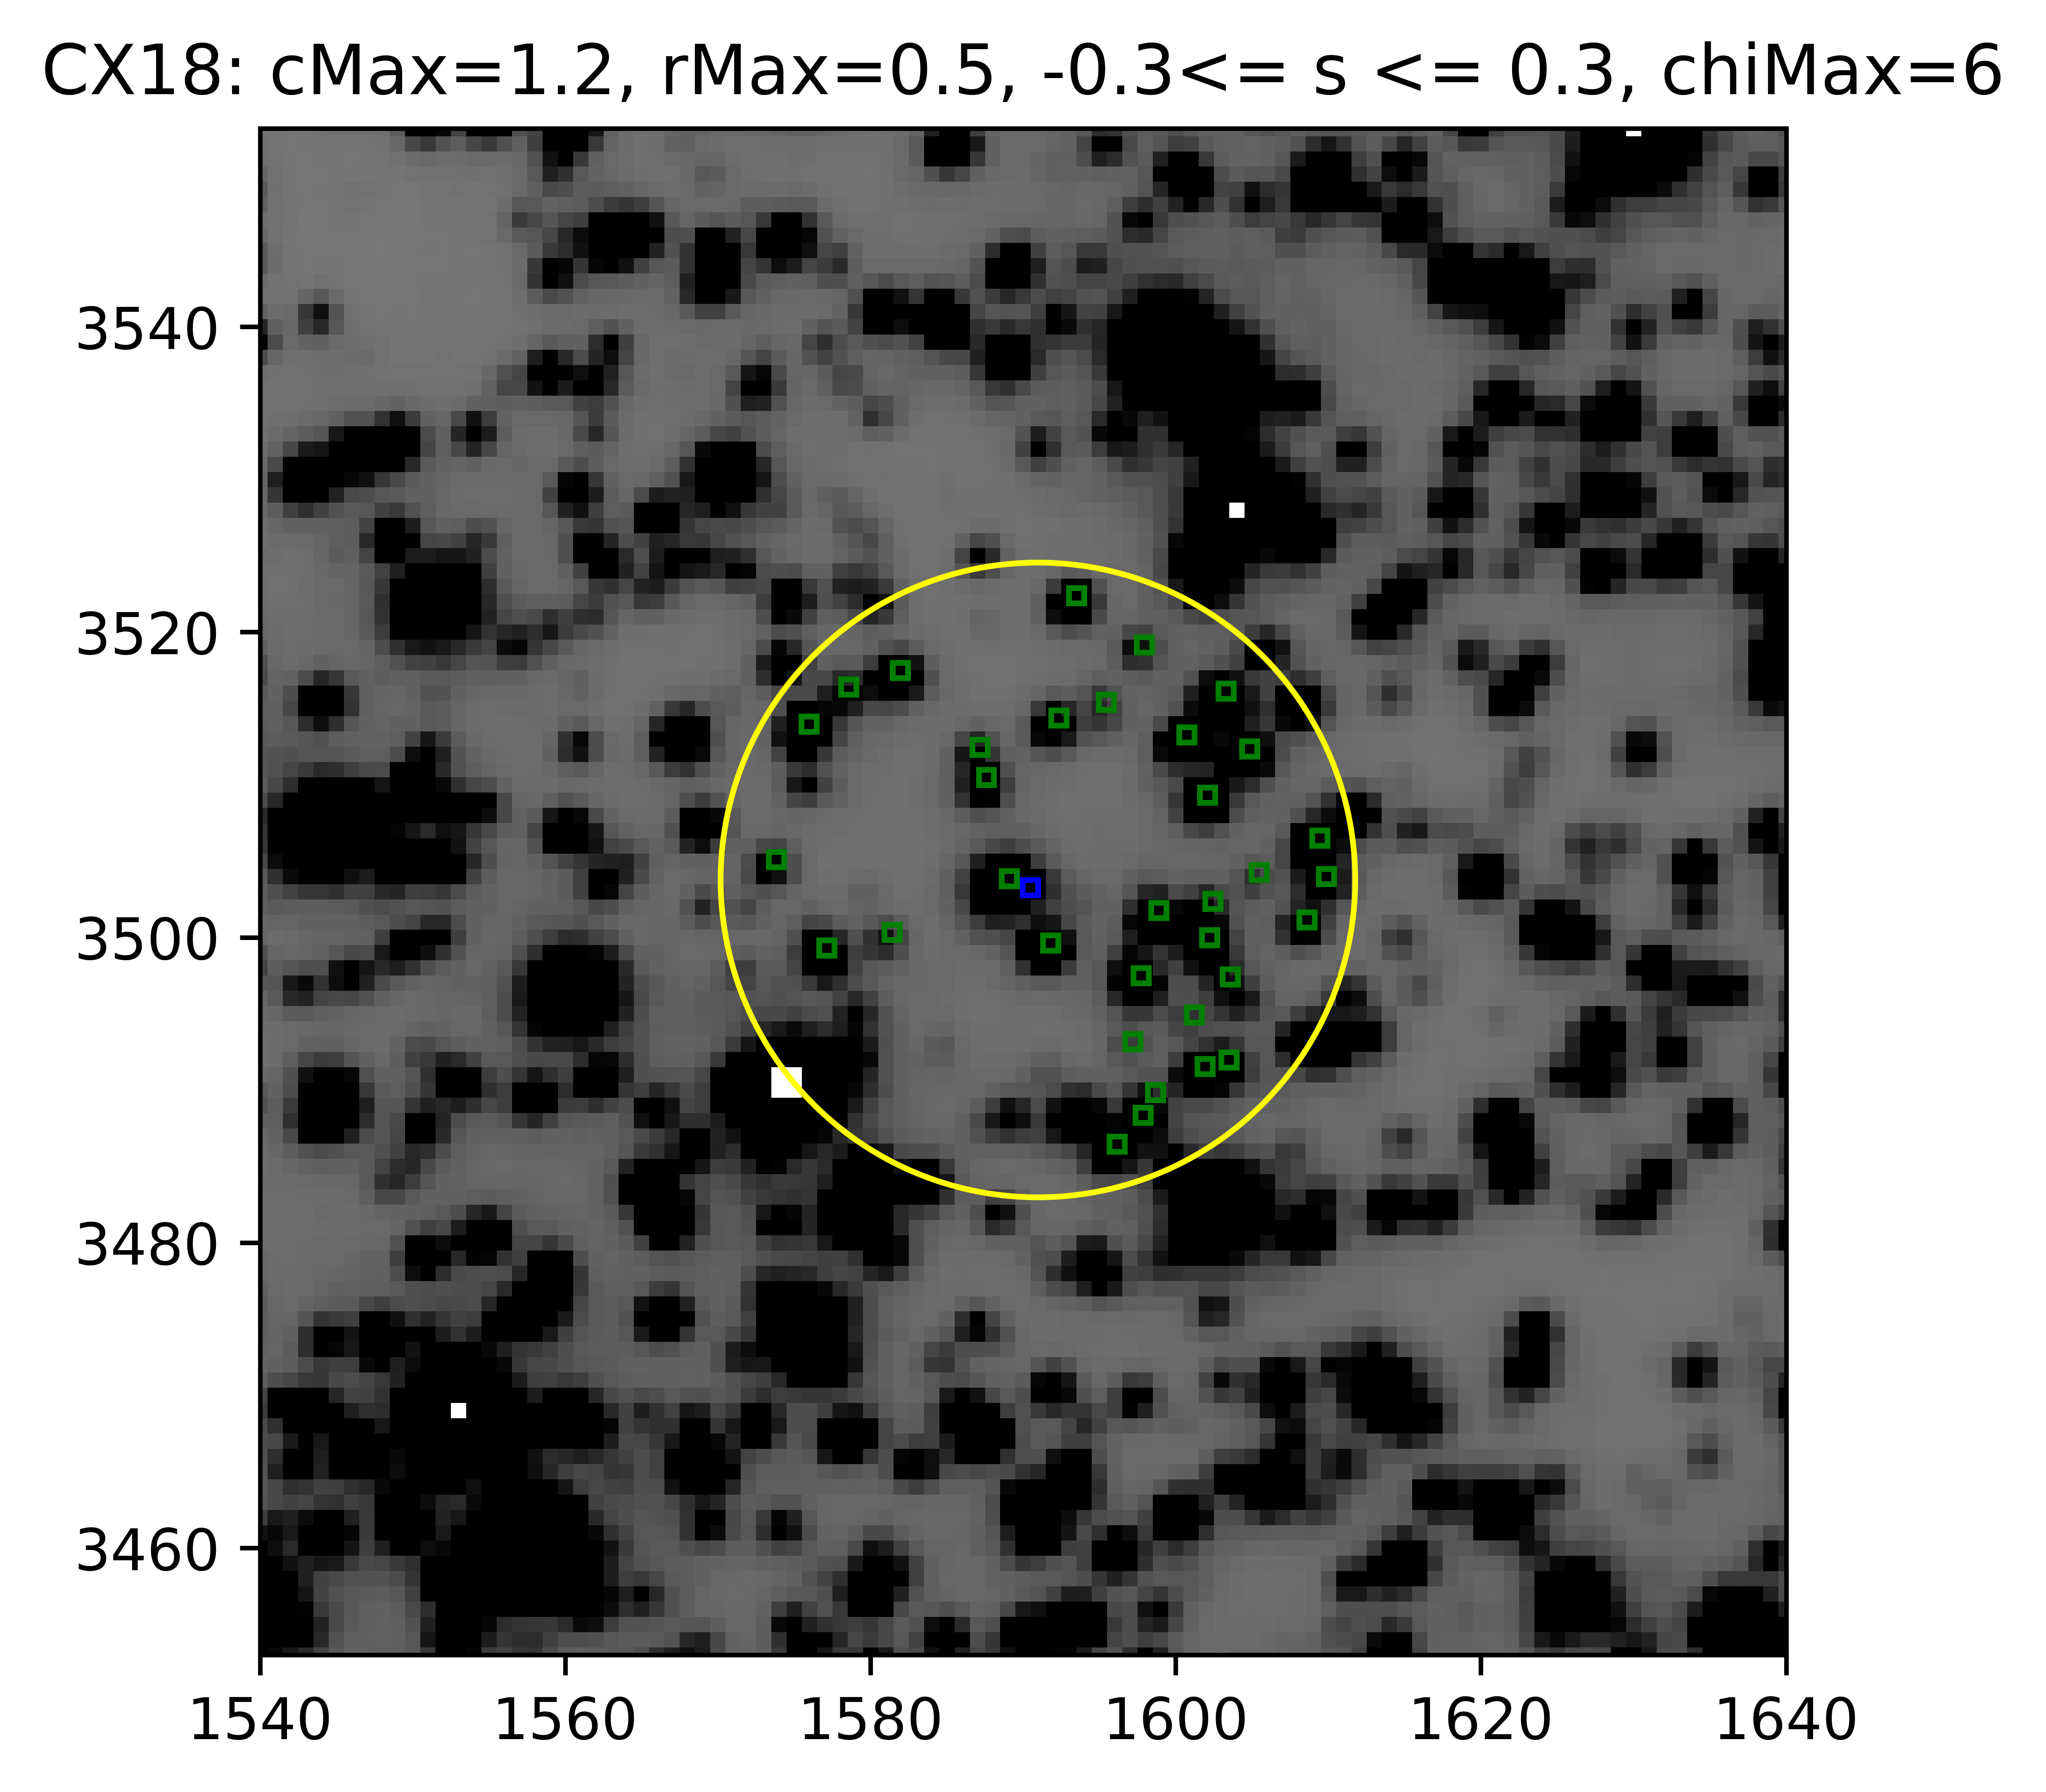

In [17]:
# Identify 4 fields - one very crowded w/ low detection, one very open with low detection, one in between, and
# one field with good results already for control
# Crowded, low - 6
# Open, low - 19
# Mid crowding - 11
# Control - 18
#
#Find a set of filters that gives good results on ALL of these images

fields = [6, 19, 11, 18]
#fields = np.arange(0,len(chandraTargets))


maxCrowding = 1.2 #  1.2
maxRoundness = 0.5 # 1
minSharp = -0.3 #   -0.3
maxSharp = 0.3#     0.3
maxChi = 6 #         6

Filter(maxCrowding, maxRoundness, minSharp, maxSharp, maxChi)


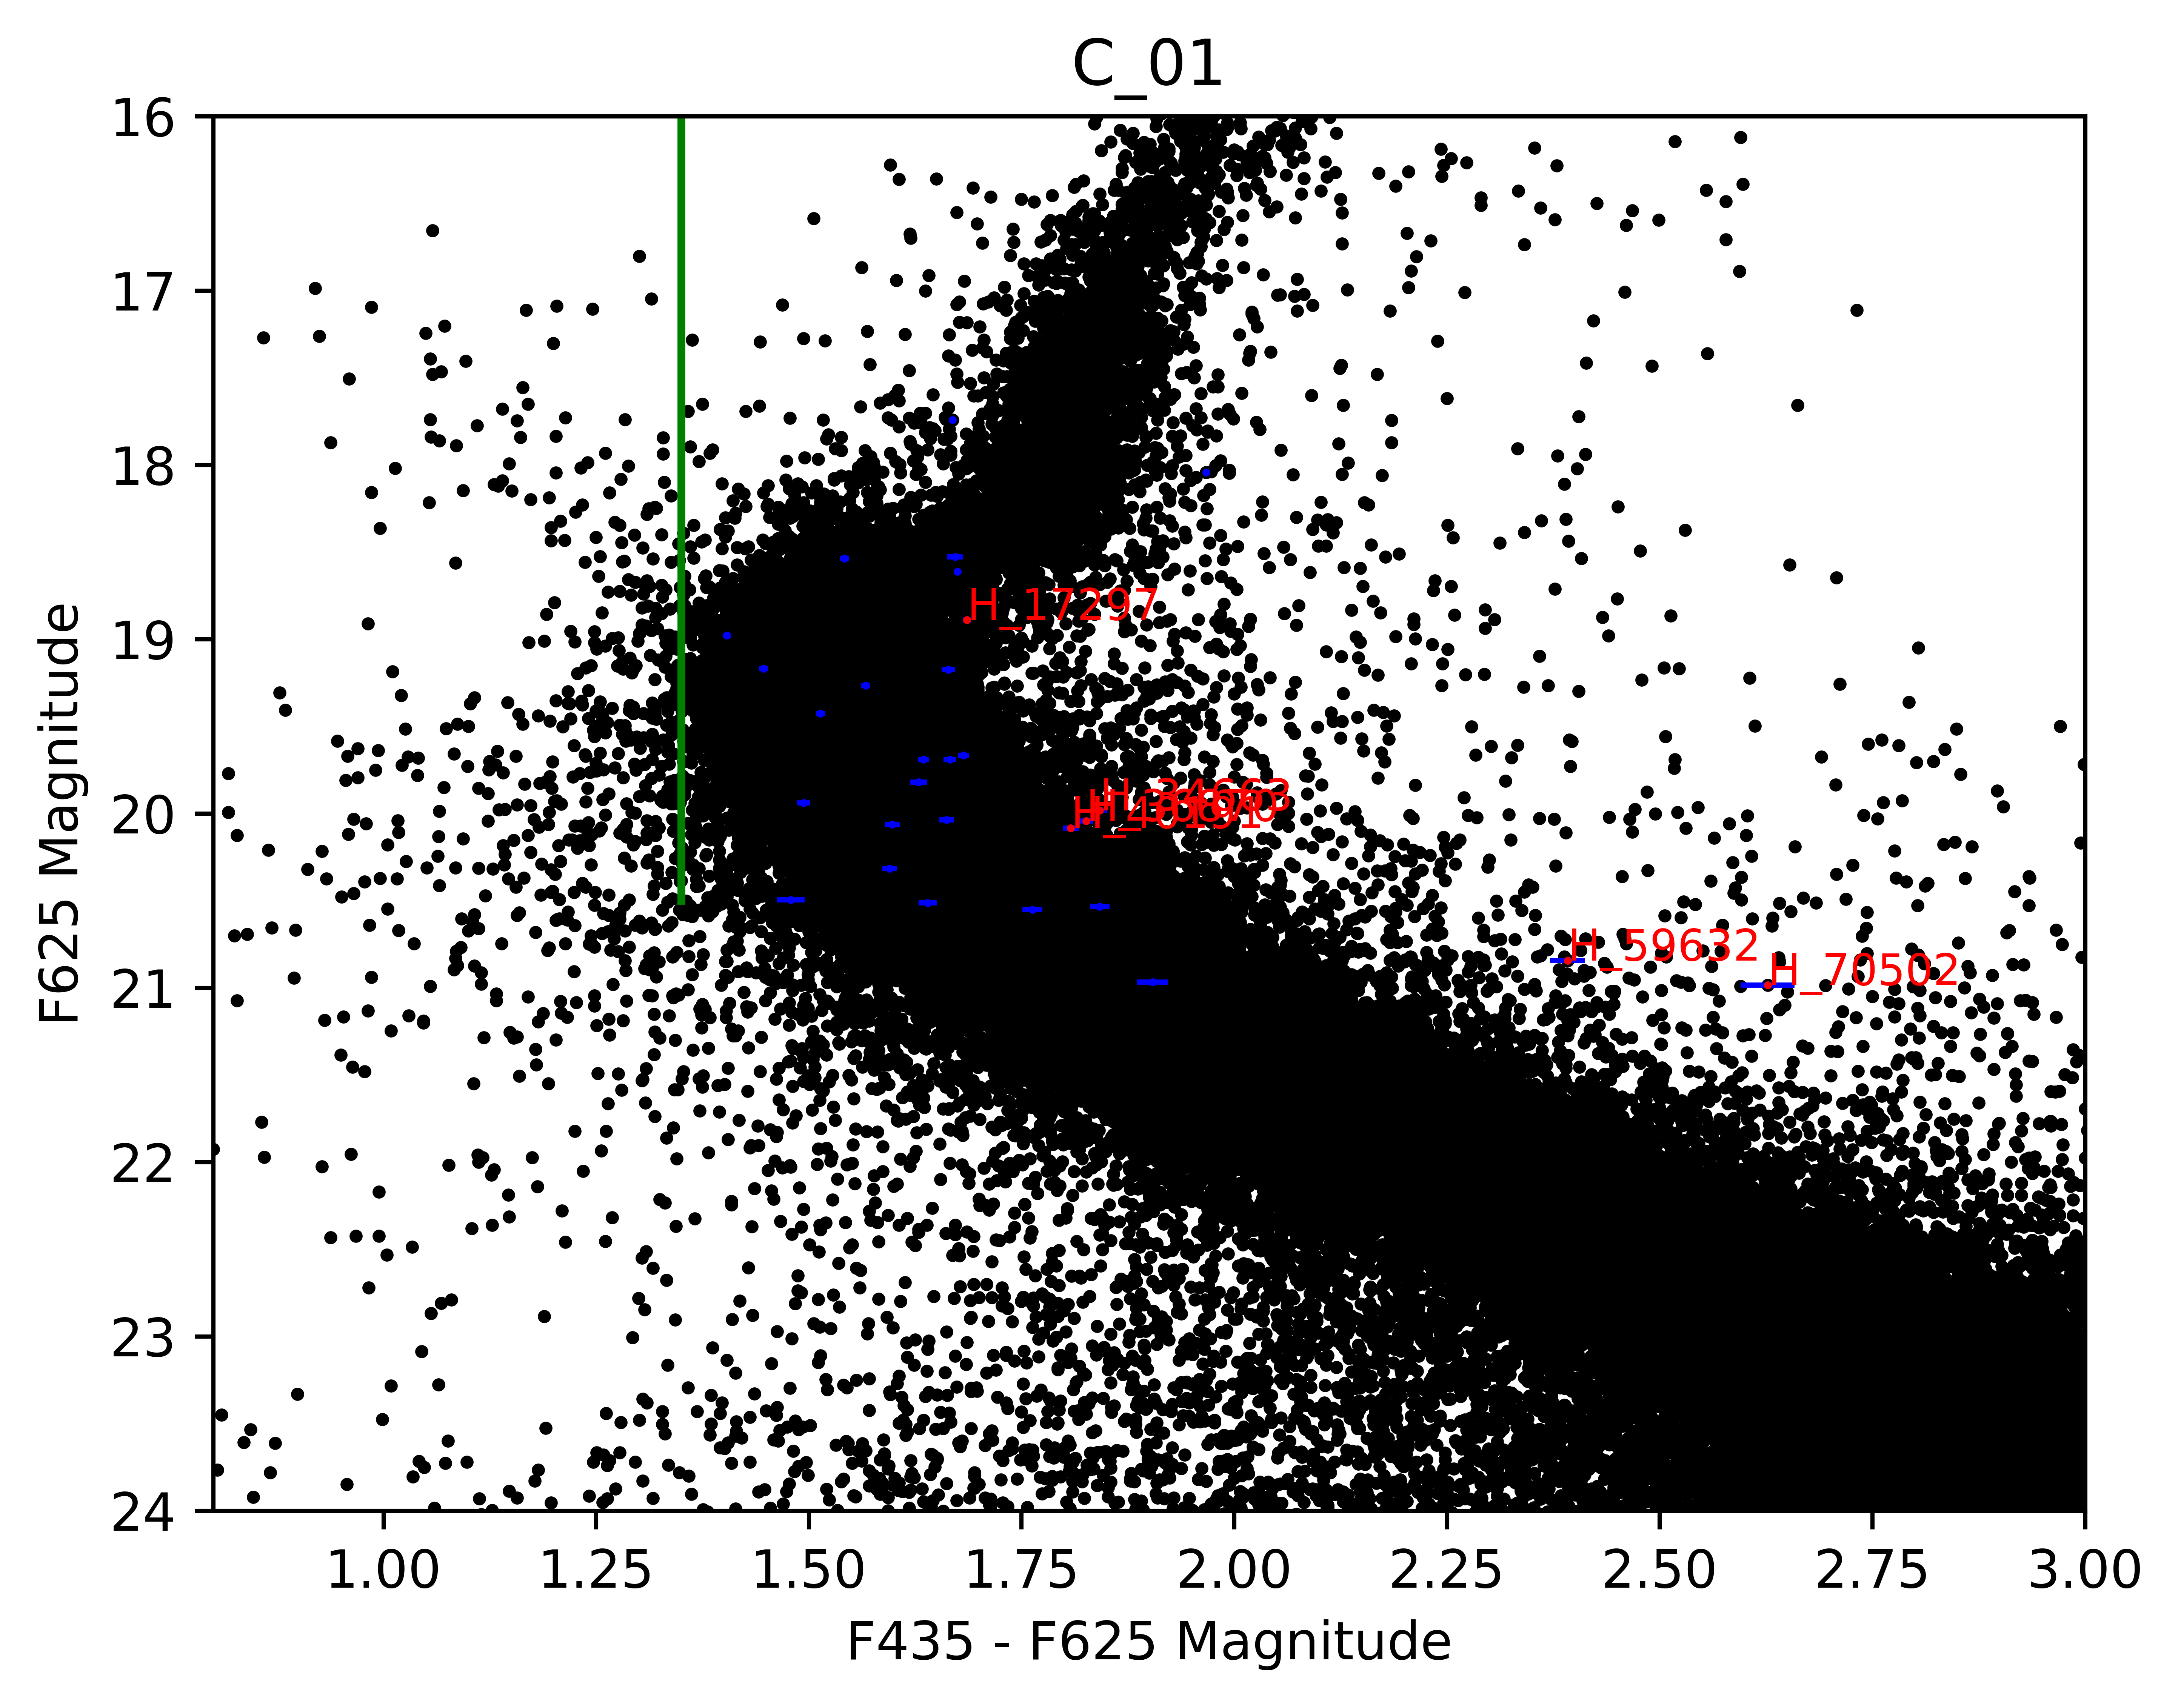

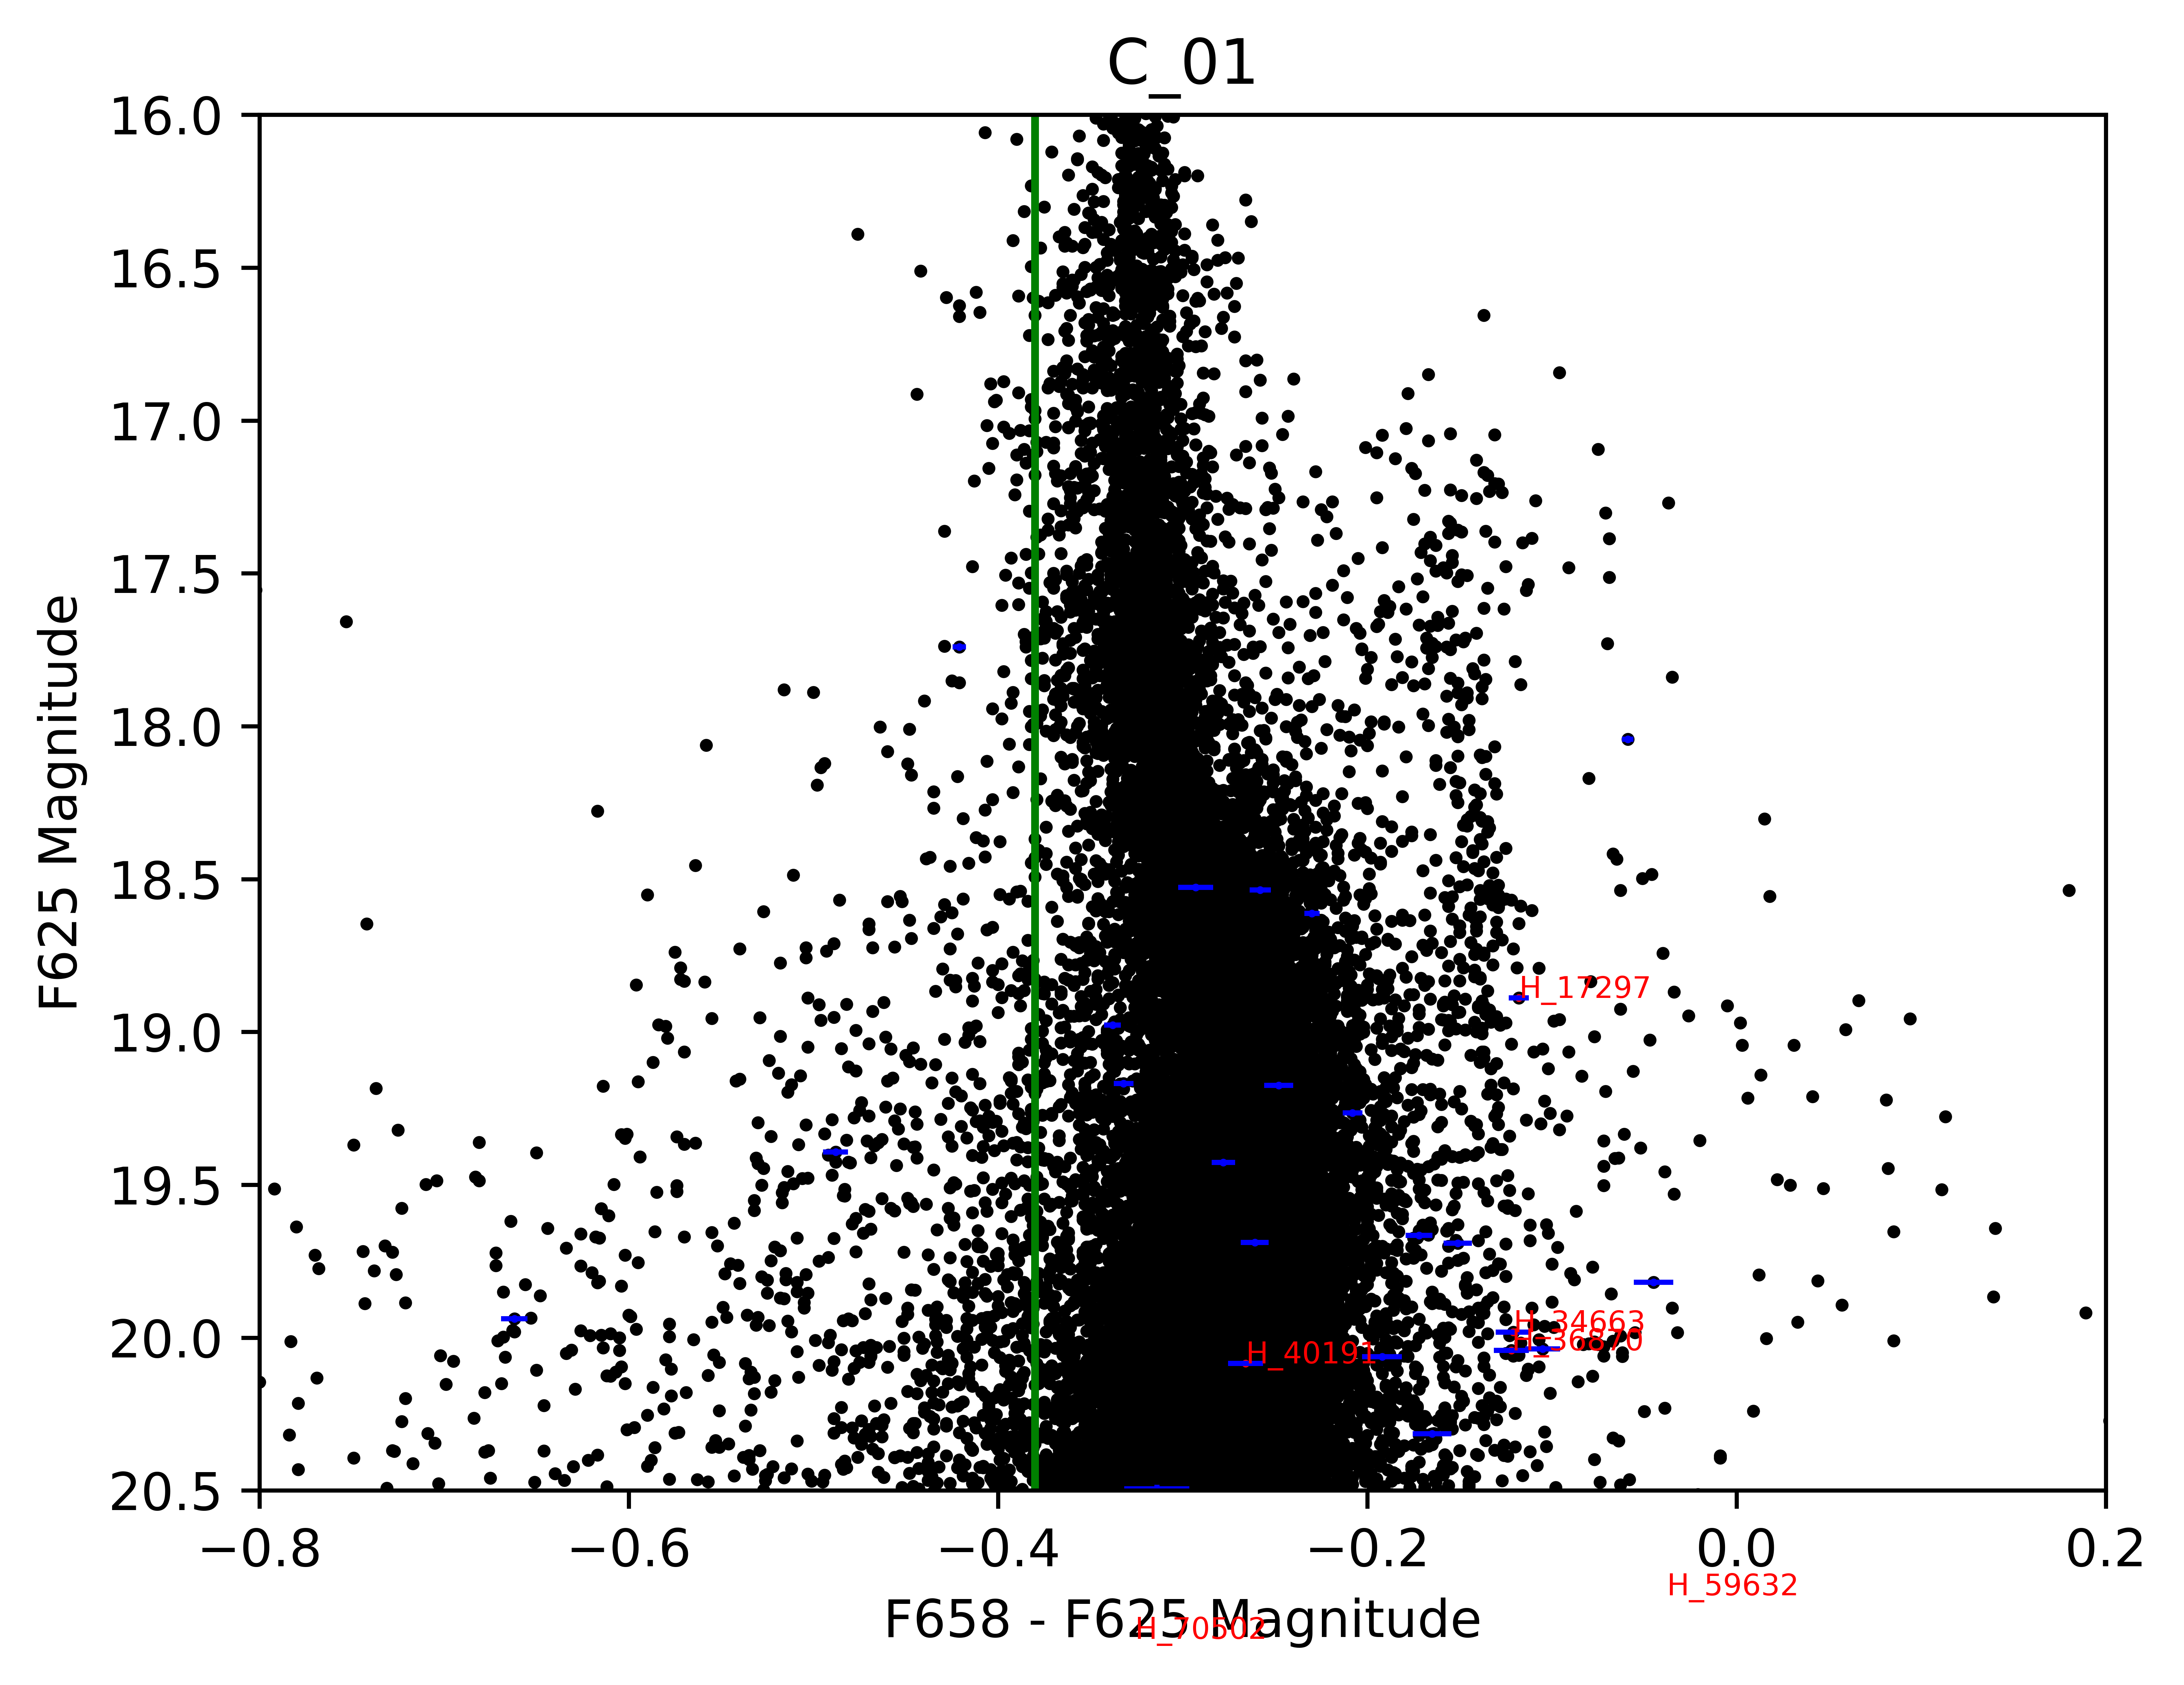

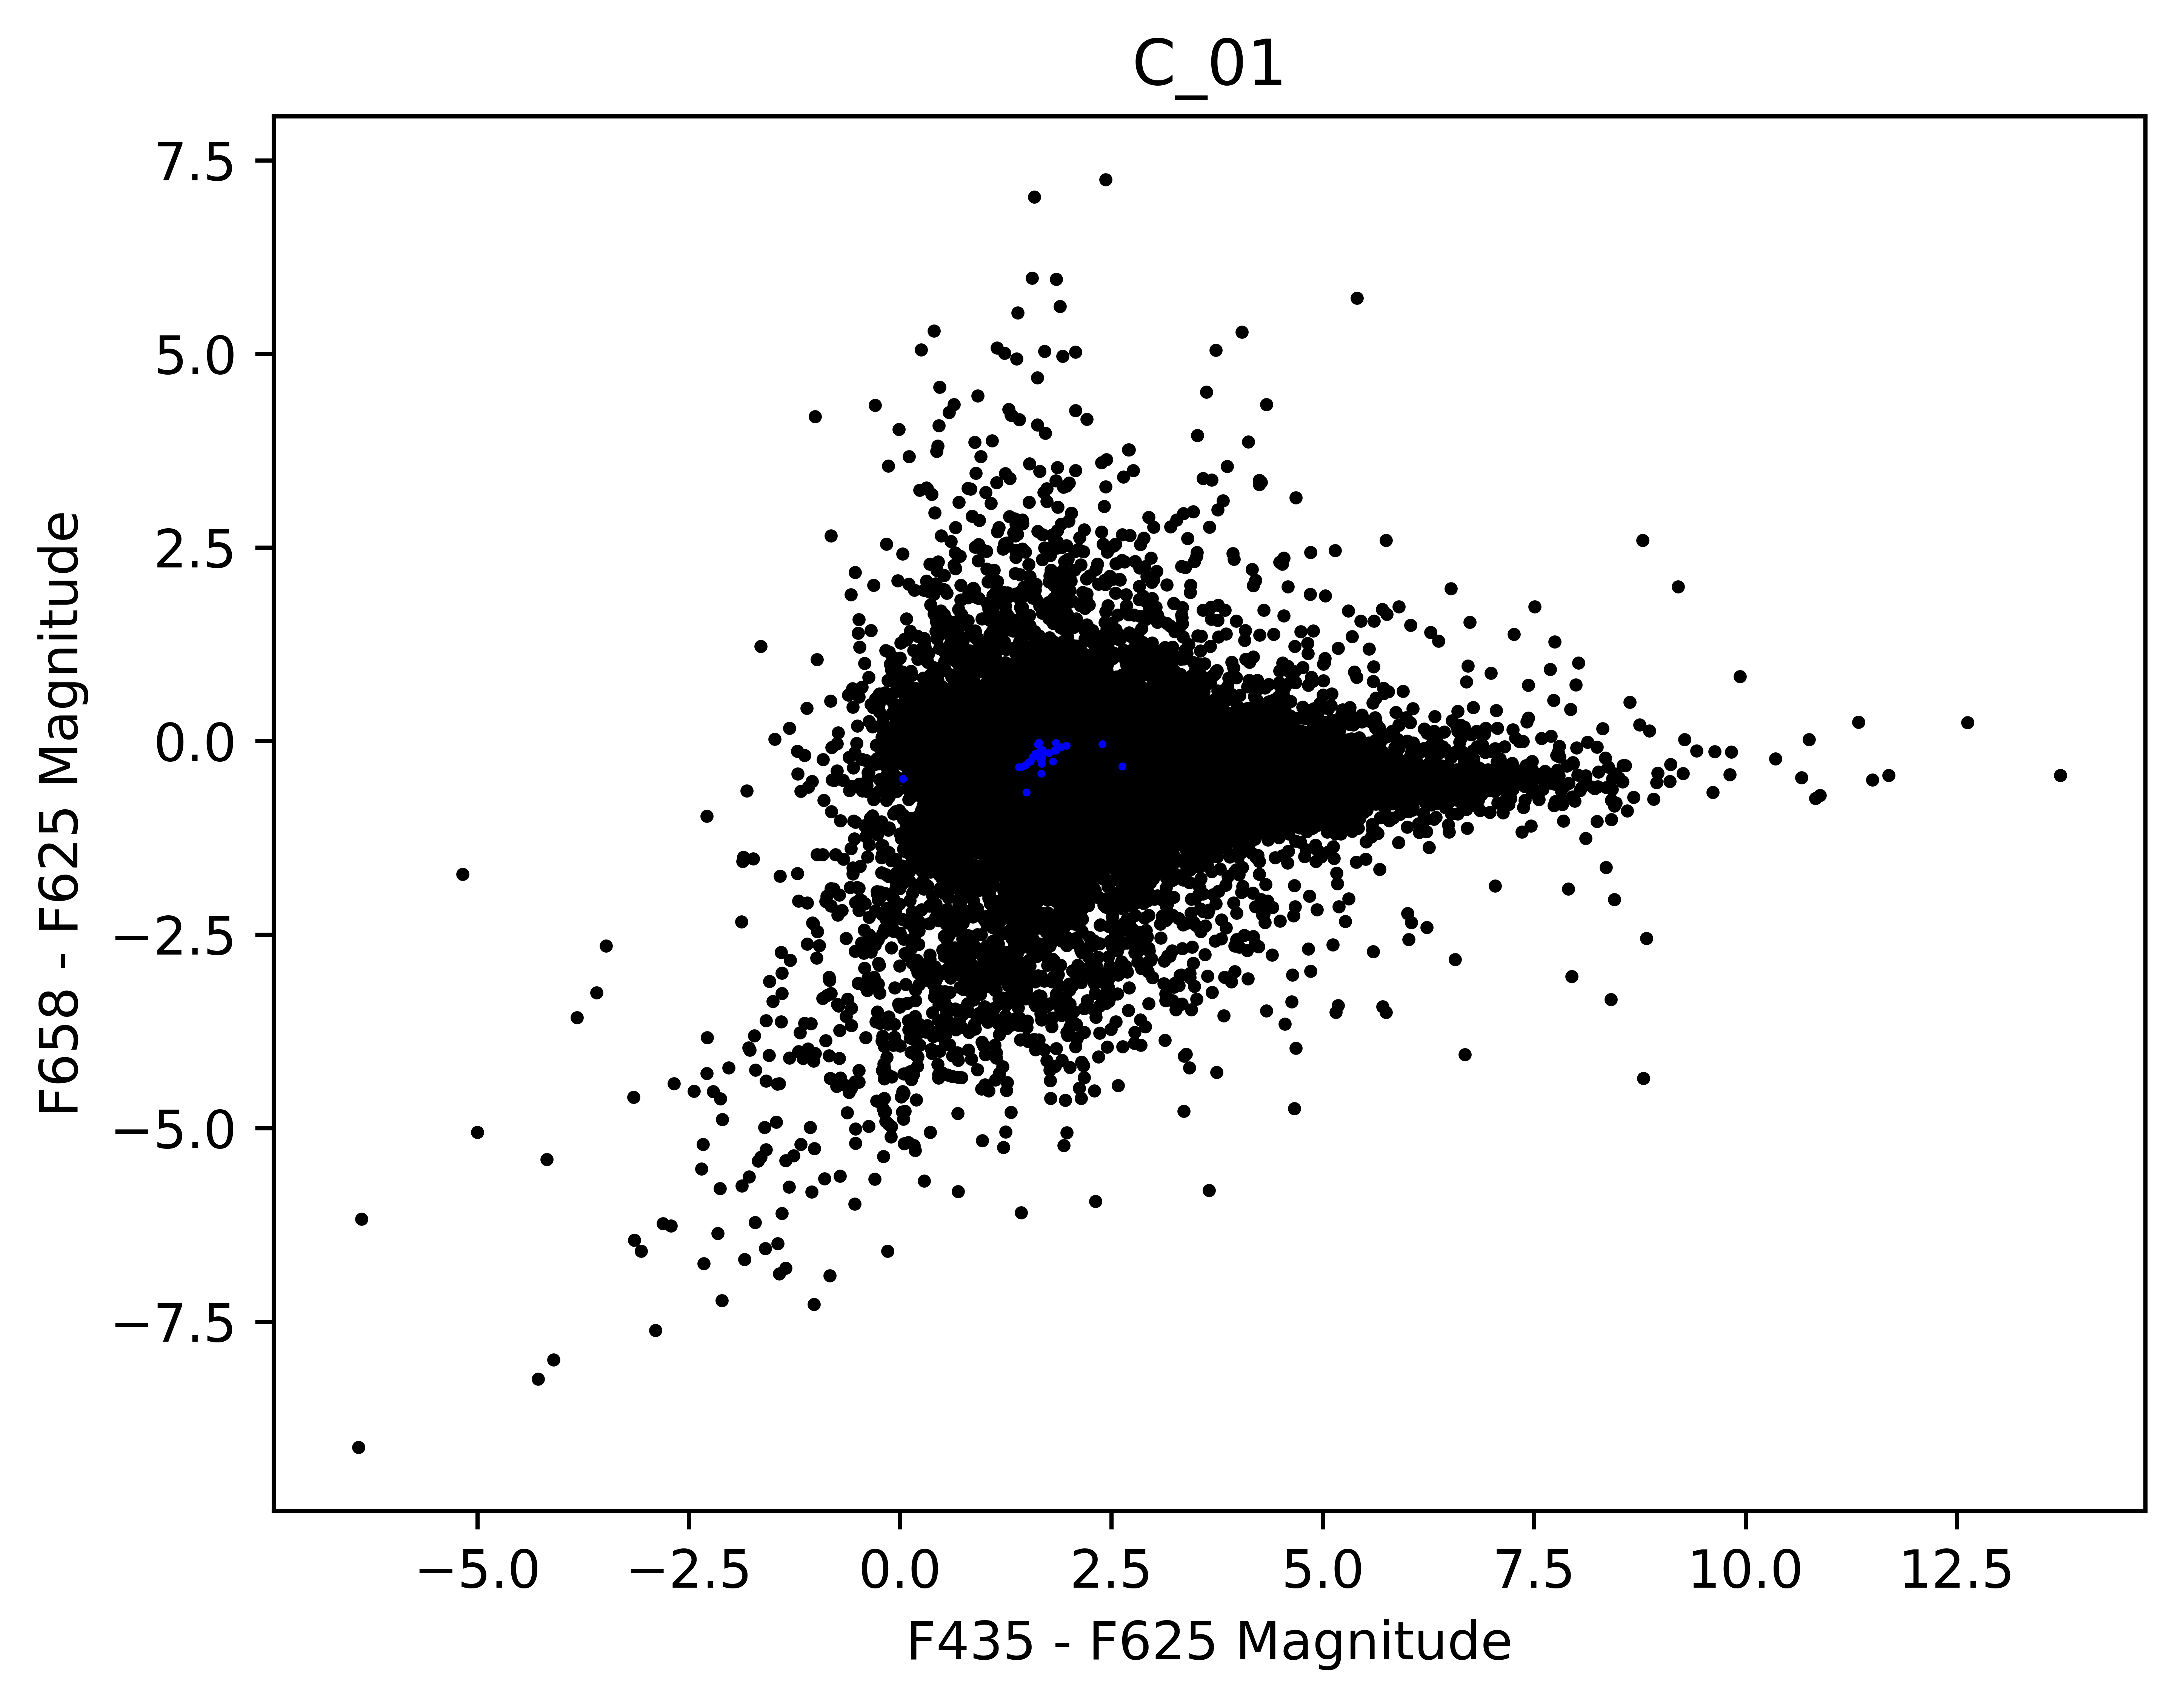

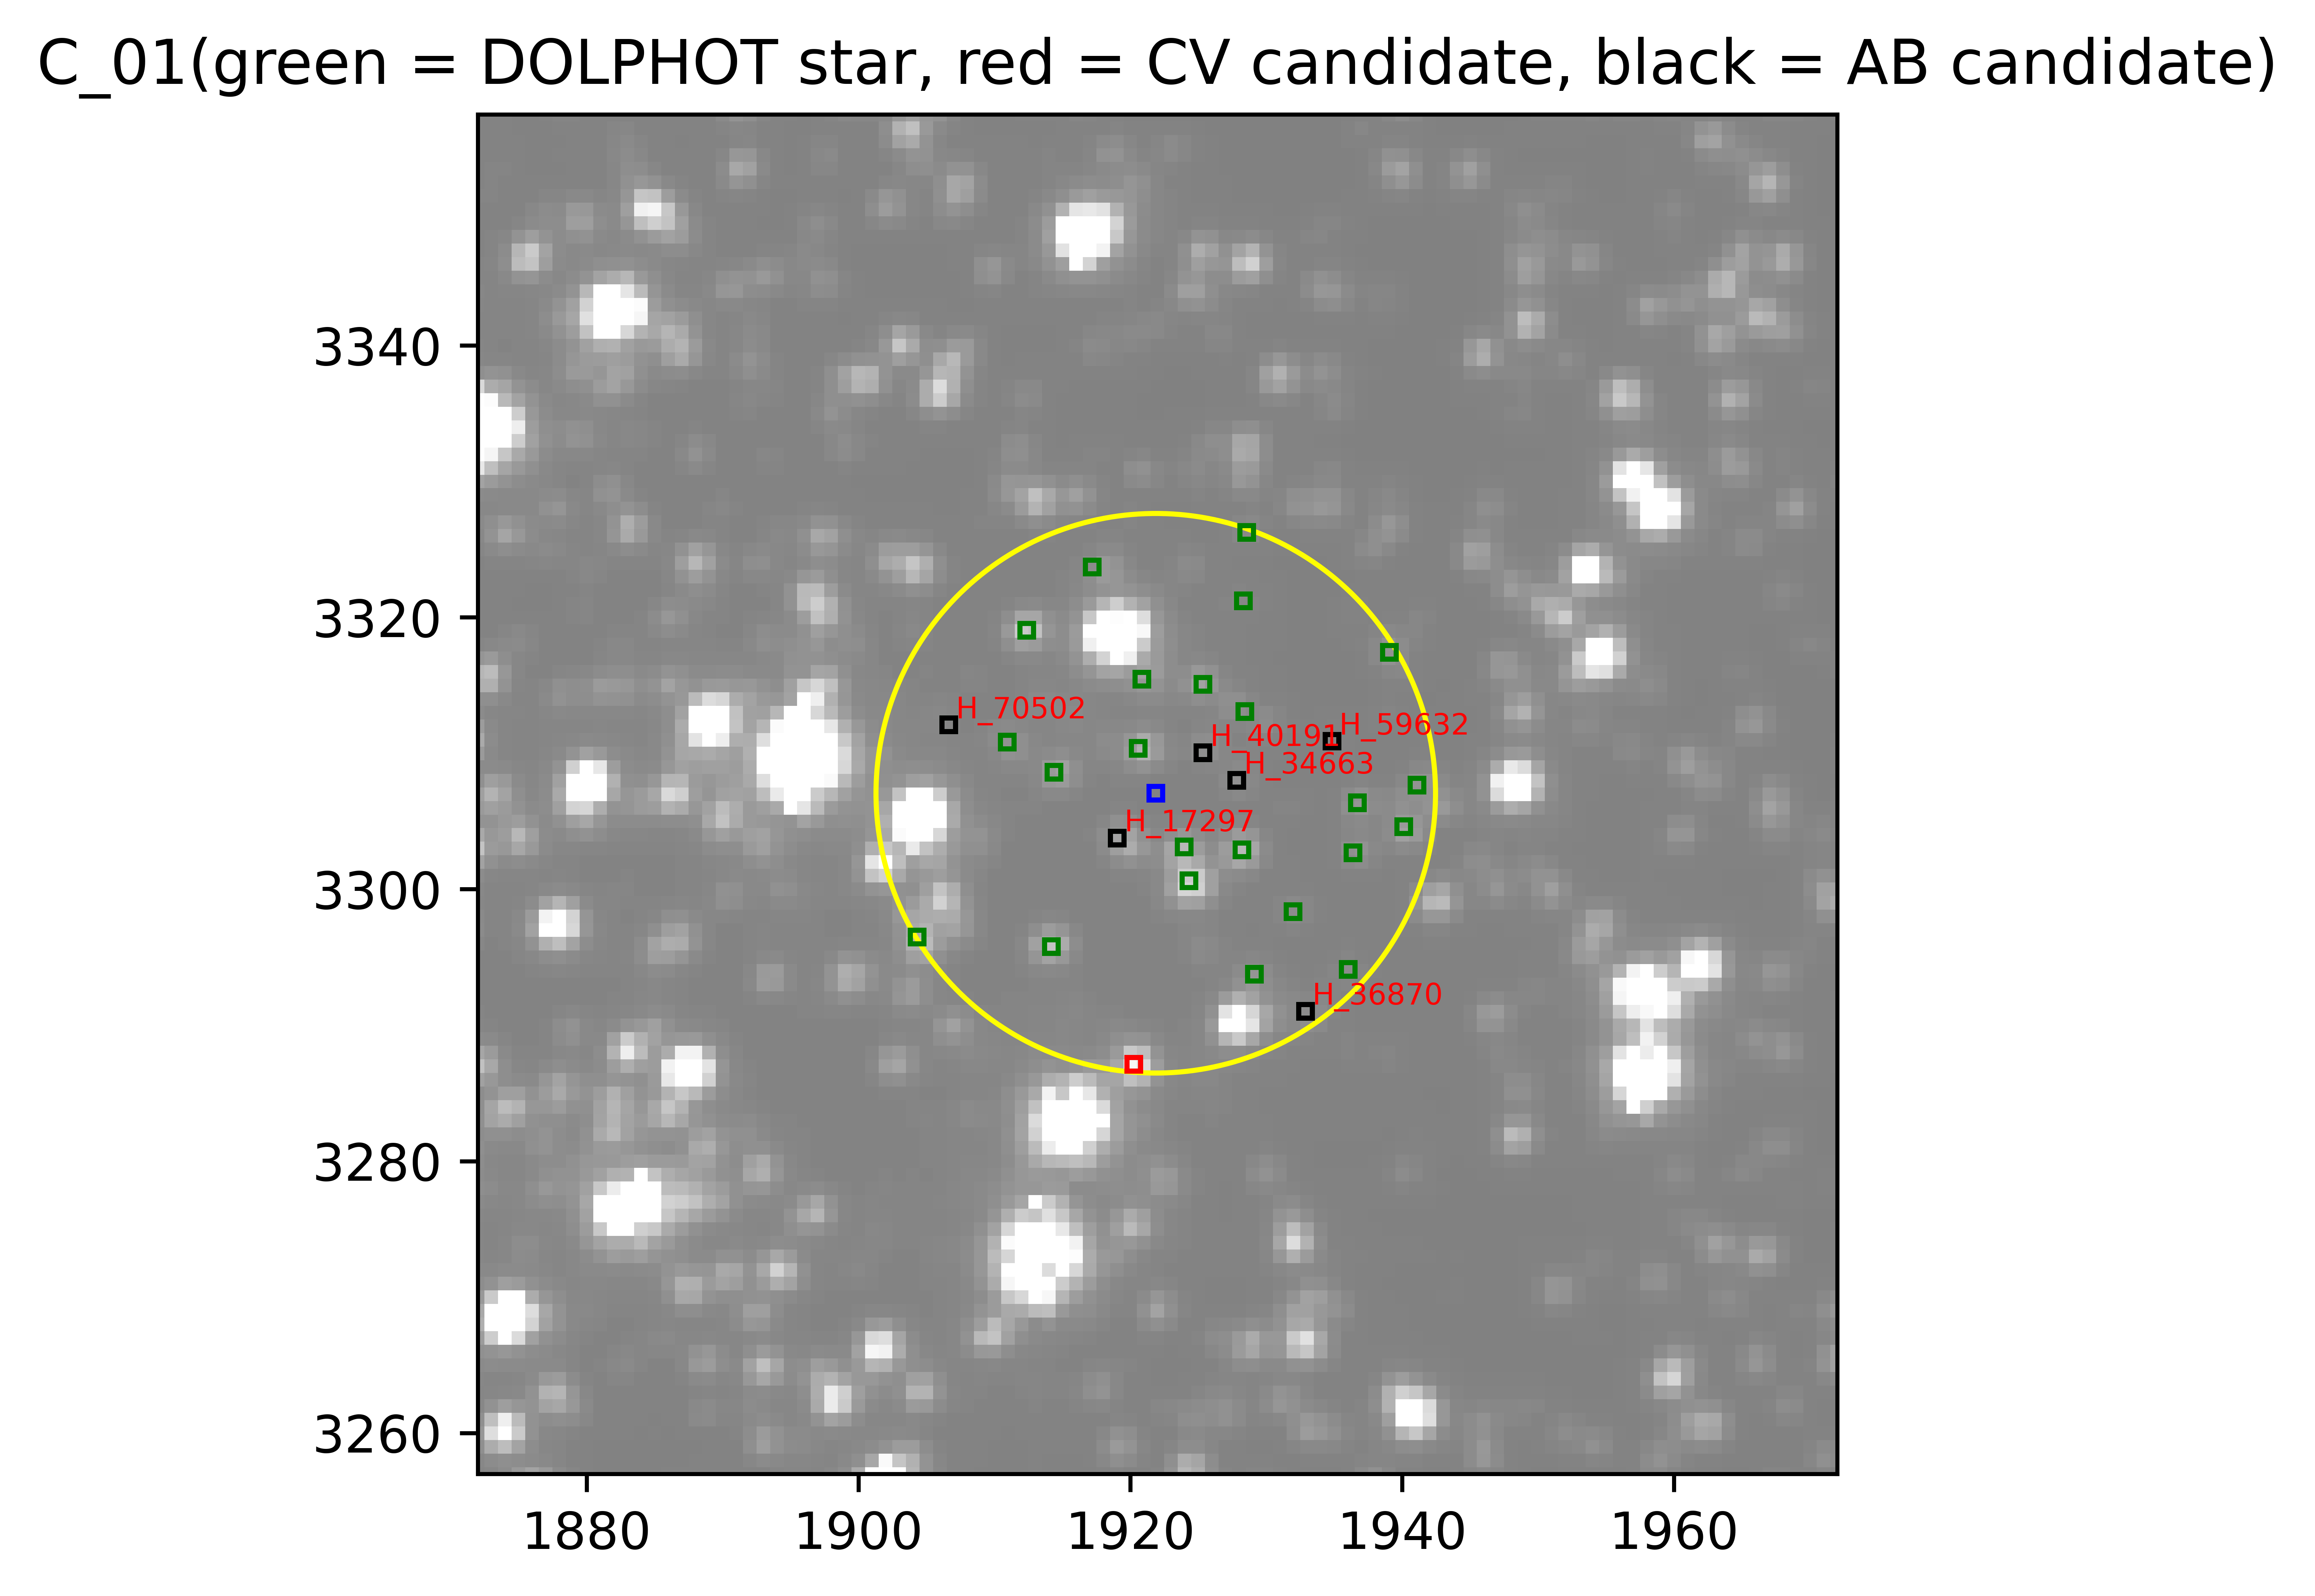

In [23]:
#Create CMDs for single field
target = 1
outliers = []
AB = []
CV = []

x1 = []
x2 = []
y1 = []
y2 = []

l1 = [1.35, 1.35]
l2 = [20.5, 16]
l3 = [-0.38, -0.38]


target = target - 1 #python indexes at 0
#title = chandraTargets[target].name + ": cMax=" + str(maxCrowding) + ", rMax=" + str(maxRoundness) + ", " + str(minSharp) + "<= s <= " + str(maxSharp) + ", chiMax=" + str(maxChi)
title = chandraTargets[target].name


for i in range(len(dolphotObjects)):
    x1.append(dolphotObjects[i].brColor)
    y1.append(dolphotObjects[i].mag625)
    x2.append(dolphotObjects[i].hrColor)
    y2.append(dolphotObjects[i].mag625)
    
    

plt.plot(x1, y1, 'k.', markersize = 3)
plt.plot(l1, l2, 'g')
plt.gca().invert_yaxis()
plt.xlim(0.8,3.0)
plt.ylim(24,16)
plt.ylabel('F625 Magnitude')
plt.xlabel('F435 - F625 Magnitude')
plt.title(title)


for i in range(len(candidates)):
    if candidates[i].parent == chandraTargets[target].name:
        plt.plot(candidates[i].brColor, candidates[i].mag625, "b.", markersize = 1)
        plt.errorbar(candidates[i].brColor, candidates[i].mag625, xerr = (candidates[i].sig435**2 + candidates[i].sig625**2)**(1/2), yerr = candidates[i].sig625, elinewidth = 1, ecolor = 'b' )
    if candidates[i].parent == chandraTargets[target].name and candidates[i].mag625 <= 18.9 and candidates[i].mag625 >= 18.75:
        plt.plot(candidates[i].brColor, candidates[i].mag625, "r.", markersize = 1)
        plt.text(candidates[i].brColor, candidates[i].mag625, candidates[i].name, color = 'r', fontsize = 'small')
        AB.append(candidates[i])
    if candidates[i].parent == chandraTargets[target].name and candidates[i].mag625 <= 20.5 and candidates[i].brColor >= 1.8 and candidates[i].brColor <= 1.85:
        plt.plot(candidates[i].brColor, candidates[i].mag625, "r.", markersize = 1)
        plt.text(candidates[i].brColor, candidates[i].mag625, candidates[i].name, color = 'r', fontsize = 'small')
        AB.append(candidates[i])
    if candidates[i].parent == chandraTargets[target].name and candidates[i].brColor >= 2.2:
        plt.plot(candidates[i].brColor, candidates[i].mag625, "r.", markersize = 1)
        plt.text(candidates[i].brColor, candidates[i].mag625, candidates[i].name, color = 'r', fontsize = 'small')
        AB.append(candidates[i])       
#plt.show()
#f = 'C:\\Python\\435-625\\' + chandraTargets[target].name + 'CMD.png'
#plt.savefig(f, bbox_inches='tight')
plt.show()
#plt.close(fig)



plt.plot(x2, y2, 'k.',markersize = 3)
plt.plot(l3, l2, 'g')

for i in range(len(candidates)):
    if candidates[i].parent == chandraTargets[target].name:
        plt.plot(candidates[i].hrColor, candidates[i].mag625, "b.", markersize = 1)
        plt.errorbar(candidates[i].hrColor, candidates[i].mag625, xerr = (candidates[i].sig658**2 + candidates[i].sig625**2)**(1/2), yerr = candidates[i].sig625, elinewidth = 1, ecolor = 'b' )
        
for i in range(len(AB)):
    plt.plot(AB[i].hrColor, AB[i].mag625, 'r.', markersize = 1)
    plt.errorbar(AB[i].hrColor, AB[i].mag625, xerr = (AB[i].sig658**2 + AB[i].sig625**2)**(1/2), yerr = AB[i].sig625, elinewidth = 1, ecolor = 'b' )
    plt.text(AB[i].hrColor, AB[i].mag625, AB[i].name, color = 'red', fontsize = 'xx-small')
plt.gca().invert_yaxis()
plt.xlim(-0.8,0.2)
plt.ylim(20.5,16)
plt.title(title)
plt.ylabel('F625 Magnitude')
plt.xlabel('F658 - F625 Magnitude')
plt.show()


plt.plot(x1, x2, 'k.', markersize=3)
plt.title(title)
plt.xlabel("F435 - F625 Magnitude")
plt.ylabel("F658 - F625 Magnitude")
#plt.xlim(-1,3.5)
#plt.ylim(-2,2)

for i in range(len(candidates)):
    if candidates[i].parent == chandraTargets[target].name:
        plt.plot(candidates[i].brColor, candidates[i].hrColor, "b.", markersize = 1)
        plt.errorbar(candidates[i].brColor, candidates[i].hrColor, xerr = (candidates[i].sig435**2 + candidates[i].sig625**2)**(1/2), yerr = ((candidates[i].sig658)**2 + (candidates[i].sig625)**2)**(1/2), elinewidth = 1, ecolor = 'b' )

plt.show()

xMin = int(chandraTargets[target].X-50)
xMax = int(chandraTargets[target].X+50)
yMin = int(chandraTargets[target].Y-50)
yMax = int(chandraTargets[target].Y+50)


image_data_Hubble = hubble.data
plotDataHubble = image_data_Hubble[xMin:xMax, yMin:yMax]

fig, ax = plt.subplots()


ax.imshow(image_data_Hubble, origin = 'lower', vmin= -5e3, vmax = 5e3, cmap = 'gray')
ax.set_xlim(xMin, xMax)
ax.set_ylim(yMin, yMax)

title = chandraTargets[target].name + '(green = DOLPHOT star, red = CV candidate, black = AB candidate)'
plt.title(title)
ax.imshow(image_data_Hubble, origin = 'lower', vmin= -5e4, vmax = 5e4, cmap = 'gray')
ax.set_xlim(xMin, xMax)
ax.set_ylim(yMin, yMax)

r = Rectangle((chandraTargets[target].X-1, chandraTargets[target].Y-1), 1, 1, edgecolor = 'blue', facecolor = 'none')#, transform = ax.get_transform('pixel'))
ax.add_patch(r)

c = Circle((chandraTargets[target].X-0.5, chandraTargets[target].Y-0.5), chandraTargets[target].errorR1, edgecolor = 'yellow', facecolor = 'none')
ax.add_patch(c)



for j in range(len(candidates)):
    if candidates[j].parent == chandraTargets[target].name: #and candidates[j].mag625 >= 20.5:
        r2 = Rectangle((candidates[j].X-1,candidates[j].Y-1), 1, 1, edgecolor = 'green', facecolor = 'none')
        ax.add_patch(r2)

#Highlight potential CVs
for j in range(len(candidates)):
    if candidates[j].parent == chandraTargets[target].name and candidates[j].mag435-candidates[j].mag625 <= 1.36:
        r2 = Rectangle((candidates[j].X-1, candidates[j].Y-1), 1, 1, edgecolor = 'red', facecolor = 'none')
        ax.add_patch(r2)
        #outliers.append(candidates[j])   
        
#Highlight potential ABs
for j in range(len(AB)):
    #if AB[j].parent == AB[target].name and AB[j].mag625 >= 1.8:
    r2 = Rectangle((AB[j].X-1, AB[j].Y-1), 1, 1, edgecolor = 'black', facecolor = 'none')
    ax.add_patch(r2)
    plt.text(AB[j].X, AB[j].Y, AB[j].name, color = 'r', fontsize = 'xx-small')
       #outliers.append(candidates[j])
        

#f = 'C:\\Python\\fields\\' + chandraTargets[target].name + '.png'
#plt.savefig(f, bbox_inches='tight')
plt.show()

In [ ]:
#Create CMDs

for i in range(len(fields)):
    #image = 1

    x1 = []
    x2 = []
    y1 = []
    y2 = []

    #l1 = [1.35, 1.35]
   # l2 = [20.5, 16]
    #l3 = [-0.8, 0.2]

    target = i
    #title = chandraTargets[target].name + ": cMax=" + str(maxCrowding) + ", rMax=" + str(maxRoundness) + ", " + str(minSharp) + "<= s <= " + str(maxSharp) + ", chiMax=" + str(maxChi)
    title = chandraTargets[target].name


    for i in range(len(dolphotObjects)):
        x1.append(dolphotObjects[i].mag435 - dolphotObjects[i].mag625)
        y1.append(dolphotObjects[i].mag625)
        x2.append(dolphotObjects[i].mag658 - dolphotObjects[i].mag625)
        y2.append(dolphotObjects[i].mag625)

    plt.plot(x1, y1, 'k.', markersize = 3)
    #plt.plot(l1, l2, 'g')
    plt.gca().invert_yaxis()
    plt.xlim(0.8,2.5)
    plt.ylim(20.5,16)
    plt.ylabel('F625 Magnitude')
    plt.xlabel('F435 - F625 Magnitude')
    plt.title(title)

    for i in range(len(candidates)):
        if candidates[i].parent == chandraTargets[target].name:
            plt.plot(candidates[i].mag435-candidates[i].mag625, candidates[i].mag625, "b.", markersize = 1)
            plt.errorbar(candidates[i].mag435-candidates[i].mag625, candidates[i].mag625, xerr = (candidates[i].sig435**2 + candidates[i].sig625**2)**(1/2), yerr = candidates[i].sig625, elinewidth = 1, ecolor = 'b' )

    #plt.show()
    f = 'C:\\Python\\435-625\\' + chandraTargets[target].name + 'CMD.png'
    #plt.savefig(f, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    #plt.plot(x2, y2, 'k.',markersize = 3)
    #plt.plot(l3, l2, 'g')

    #for i in range(len(candidates)):
    #    if candidates[i].parent == chandraTargets[target].name:
    #        plt.plot(candidates[i].mag658-candidates[i].mag625, candidates[i].mag625, "b.", markersize = 1)
    #        plt.errorbar(candidates[i].mag658-candidates[i].mag625, candidates[i].mag625, xerr = (candidates[i].sig658**2 + candidates[i].sig625**2)**(1/2), yerr = candidates[i].sig625, elinewidth = 1, ecolor = 'b' )
    #plt.gca().invert_yaxis()
    #plt.xlim(-0.8,0.2)
    #plt.ylim(20.5,16)
    #plt.title(title)
    #plt.ylabel('F625 Magnitude')
    #plt.xlabel('F658 - F625 Magnitude')
    #plt.show()


In [ ]:
#Create field images displaying only accepted + outliers stars
outliers = []
for i in range(len(fields)):
    target = i
    
    xMin = int(chandraTargets[target].X-50)
    xMax = int(chandraTargets[target].X+50)
    yMin = int(chandraTargets[target].Y-50)
    yMax = int(chandraTargets[target].Y+50)


    image_data_Hubble = hubble.data
    plotDataHubble = image_data_Hubble[xMin:xMax, yMin:yMax]

    fig, ax = plt.subplots()


    ax.imshow(image_data_Hubble, origin = 'lower', vmin= -5e3, vmax = 5e3, cmap = 'gray')
    ax.set_xlim(xMin, xMax)
    ax.set_ylim(yMin, yMax)

    title = chandraTargets[target].name
    plt.title(title)
    ax.imshow(image_data_Hubble, origin = 'lower', vmin= -5e3, vmax = 5e3, cmap = 'gray')
    ax.set_xlim(xMin, xMax)
    ax.set_ylim(yMin, yMax)

    r = Rectangle((chandraTargets[target].X-1, chandraTargets[target].Y-1), 1, 1, edgecolor = 'blue', facecolor = 'none')#, transform = ax.get_transform('pixel'))
    ax.add_patch(r)

    c = Circle((chandraTargets[target].X-0.5, chandraTargets[target].Y-0.5), chandraTargets[target].errorR1, edgecolor = 'yellow', facecolor = 'none')
    ax.add_patch(c)
    


    for j in range(len(candidates)):
        if candidates[j].parent == chandraTargets[target].name: #and candidates[j].mag625 >= 20.5:
            r2 = Rectangle((candidates[j].X-1,candidates[j].Y-1), 1, 1, edgecolor = 'green', facecolor = 'none')
            ax.add_patch(r2)

    #Highlight outliers
    for j in range(len(candidates)):
        if candidates[j].parent == chandraTargets[target].name and candidates[j].mag435-candidates[j].mag625 <= 1.35:
            r2 = Rectangle((candidates[j].X-1, candidates[j].Y-1), 1, 1, edgecolor = 'red', facecolor = 'none')
            ax.add_patch(r2)
            outliers.append(candidates[j])
     
    f = 'C:\\Python\\fields\\' + chandraTargets[target].name + '.png'
    plt.savefig(f, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [ ]:
#Create field images displaying stars that have been removed + accepted stars
totalOutliers = 0
for i in range(len(fields)):
    target = i
    
    xMin = int(chandraTargets[target].X-50)
    xMax = int(chandraTargets[target].X+50)
    yMin = int(chandraTargets[target].Y-50)
    yMax = int(chandraTargets[target].Y+50)


    image_data_Hubble = hubble.data
    plotDataHubble = image_data_Hubble[xMin:xMax, yMin:yMax]

    fig, ax = plt.subplots()


    ax.imshow(image_data_Hubble, origin = 'lower', vmin= -5e3, vmax = 5e3, cmap = 'gray')
    ax.set_xlim(xMin, xMax)
    ax.set_ylim(yMin, yMax)

    title = chandraTargets[target].name + 'Unfiltered'
    plt.title(title)
    ax.imshow(image_data_Hubble, origin = 'lower', vmin= -5e3, vmax = 5e3, cmap = 'gray')
    ax.set_xlim(xMin, xMax)
    ax.set_ylim(yMin, yMax)

    r = Rectangle((chandraTargets[target].X-1, chandraTargets[target].Y-1), 1, 1, edgecolor = 'blue', facecolor = 'none')#, transform = ax.get_transform('pixel'))
    ax.add_patch(r)

    c = Circle((chandraTargets[target].X-0.5, chandraTargets[target].Y-0.5), chandraTargets[target].errorR1, edgecolor = 'yellow', facecolor = 'none')
    ax.add_patch(c)
    
    for j in range(len(xPos)):
        #if dolphotObjects[j].parent == chandraTargets[target].name:# and candidates[j].mag435-candidates[j].mag625 <= 1.35:
        if ((xPos[j]- chandraTargets[target].X)**2+(yPos[j] - chandraTargets[target].Y)**2)**(1/2) <= chandraTargets[target].errorR1:
            r2 = Rectangle((xPos[j]-1, yPos[j]-1), 1, 1, edgecolor = 'red', facecolor = 'none')
            ax.add_patch(r2)

    for j in range(len(candidates)):
        if candidates[j].parent == chandraTargets[target].name: #and candidates[j].mag625 >= 20.5:
            r2 = Rectangle((candidates[j].X-1,candidates[j].Y-1), 1, 1, edgecolor = 'green', facecolor = 'none')
            ax.add_patch(r2)

    #Highlight outliers
   
            #totalOutliers = totalOutliers + 1
     
    f = 'C:\\Python\\unfilteredFields\\' + chandraTargets[target].name + 'unfiltered.png'
    plt.savefig(f, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [ ]:
err1 = []
err2 = []
err3 = []
m625 = []
m435 = []
m658 = []
for i in range(len(dolphotObjects)):
    err1.append(dolphotObjects[i].sig625)
    err2.append(dolphotObjects[i].sig435)
    err3.append(dolphotObjects[i].sig658)
    m625.append(dolphotObjects[i].mag625)
    m435.append(dolphotObjects[i].mag435)
    m658.append(dolphotObjects[i].mag658)


In [ ]:
print(sum(err1)/len(err1))

In [ ]:
plt.plot(m625, err1, 'k.')
plt.xlim(15,27)
plt.ylim(0,0.5)
plt.xlabel('F625 Magnitude')
plt.ylabel('F625 Uncertainty')
plt.title("Magnitude vs Uncertainty in DOLPHOT Measurements on F625W")

for i in range(len(dolphotObjects)):
    if dolphotObjects[i].mag625 >= 22.5 and dolphotObjects[i].mag625 <= 23.5 and err1[i] >=0.1: #30-second exp track
    #if dolphotObjects[i].mag625 >= 23 and dolphotObjects[i].mag625 <= 23.5 and err1[i] >=0.05 and err1[i] <0.075: #120
    #if dolphotObjects[i].mag625 >= 23 and dolphotObjects[i].mag625 <= 23.5 and err1[i] <=0.035: #340 sec
        print(dolphotObjects[i].mag625, err1[i])
        plt.plot(dolphotObjects[i].mag625, err1[i], 'r.', markersize = 3)


In [ ]:
for i in range(len(dolphotObjects)):
    if dolphotObjects[i].mag625 == 22.787 and dolphotObjects[i].sig625 == 0.126:
        print(dolphotObjects[i].X, dolphotObjects[i].Y, dolphotObjects[i].objType, dolphotObjects[i].error, dolphotObjects[i].sharpness)
        print(dolphotObjects[i].mag435, dolphotObjects[i].mag658)